In [1]:
import pandas as pd
import numpy as np
import json
from xgboost import XGBClassifier
import xgboost as xgb 

In [97]:
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from pylab import *
import sklearn
from sklearn.decomposition import PCA
from pandas.core.frame import DataFrame
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn.linear_model import LogisticRegression as LR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, roc_auc_score, accuracy_score,mean_absolute_percentage_error,mean_squared_log_error
from matplotlib.pyplot import MultipleLocator
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.inspection import permutation_importance

In [3]:
from tqdm.auto import tqdm

In [46]:
Model1_FI = pd.read_excel('/Users/Macbook/Desktop/规模预测/Model1 FI.xlsx')

In [47]:
Model2_FI = pd.read_excel('/Users/Macbook/Desktop/规模预测/Model2 FI.xlsx')

In [7]:
Model3_k_df = pd.read_excel('/Users/Macbook/Desktop/规模预测/Model3 K.xlsx')

In [8]:
Model3_t_df = pd.read_excel('/Users/Macbook/Desktop/规模预测/Model3 T.xlsx')

In [83]:
Compare_K = pd.read_excel('/Users/Macbook/Desktop/规模预测/Compare K.xlsx')

In [84]:
Compare_T = pd.read_excel('/Users/Macbook/Desktop/规模预测/Compare T.xlsx')

In [102]:
Compare_K_MAPE = pd.read_excel('/Users/Macbook/Desktop/规模预测/Compare K_MAPE.xlsx')

In [103]:
Compare_T_MAPE = pd.read_excel('/Users/Macbook/Desktop/规模预测/Compare T_MAPE.xlsx')

In [94]:
binary_t = pd.read_excel('/Users/Macbook/Desktop/规模预测/data/binary_data_t.xlsx') #binary dataset when peeking t hours
binary_k = pd.read_excel('/Users/Macbook/Desktop/规模预测/data/binary_data_k.xlsx')#binary dataset when peeking k users

# Figure 2

In [4]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

alist = [['a', 0], ['a', 'b', 1], ['a', 'c', 3],['b', 'd', 4], 
         ['c', 'e', 6], ['c', 'f', 7], ['d', 'g', 10], ['c', 'h', 11]]

g = nx.Graph()
for i in alist:
    if len(i) == 2:
        n1, t = i
        g.add_node(n1)
    else:
        n1, n2, t = i
        g.add_edge(n1, n2)

pos={'a': np.array([ 0 , 0.5]),
     'b': np.array([ 1,  0.55]),
     'c': np.array([ 3,  0.45]),
     'd': np.array([ 4,  0.55]),
     'e': np.array([ 6,  0.5]),
     'f': np.array([ 7,  0.4]),
     'g': np.array([ 10,  0.55 ]),
     'h': np.array([ 11,  0.45])}

temporal_network = {}
for k in range(1, len(alist)+1):
    elist = alist[:k]
    t = elist[-1][-1]
    temporal_network[t] = nx.Graph()
    for i in elist:
        if len(i) == 2:
            n1 = i[:-1][0]
            temporal_network[t].add_node(n1)
        else:
            n1, n2 = i[:-1]
            temporal_network[t].add_edge(n1, n2)


In [5]:
#calculate the size of the cascade
def calc_size(G):
    num_nodes=G.number_of_nodes()
    return num_nodes

#calculate the depth of the cascade
def calc_depth(G,G_root):
    depth=nx.eccentricity(G,v=G_root)
    return depth

#calculate the structural viralty of the cascade
def calc_structural_viralty(G):
    size = calc_size(G)
    if size==1:
        return 0 ##virality is not defined for cascades of size 1,
    sv=nx.average_shortest_path_length(G)  #Note: this is very time-consuming for larger cascades
    return sv

#calculate the max breadth of the cascade
def calc_max_breadth(g, root):
    depth = calc_depth(g,root)
    if depth ==0:
        return 0
    else:
        g_in_radius = [len(nx.ego_graph(g, root, radius=i).nodes())-1 for i in range(1, depth+1)]
        breadth_list = [i-g_in_radius[k-1] if k > 0 else i for k, i in enumerate(g_in_radius)]
        return np.max(breadth_list)

ts = list(temporal_network.keys())
t = list(range(np.max(ts)+1))
sizes = [len(temporal_network[i].nodes()) if i in ts else None for i in t]
depths = [calc_depth(temporal_network[i], 'a') if i in ts else None for i in t]
viralty = [calc_structural_viralty(temporal_network[i]) if i in ts else None for i in t]
breadths = [calc_max_breadth(temporal_network[i], 'a') if i in ts else None for i in t]

df  = pd.DataFrame(np.array([t, sizes, depths, breadths, viralty]).T, 
                   columns = ['t', 'size', 'depth', 'breadth', 'viralty'] )
df = df.fillna(method = 'ffill')

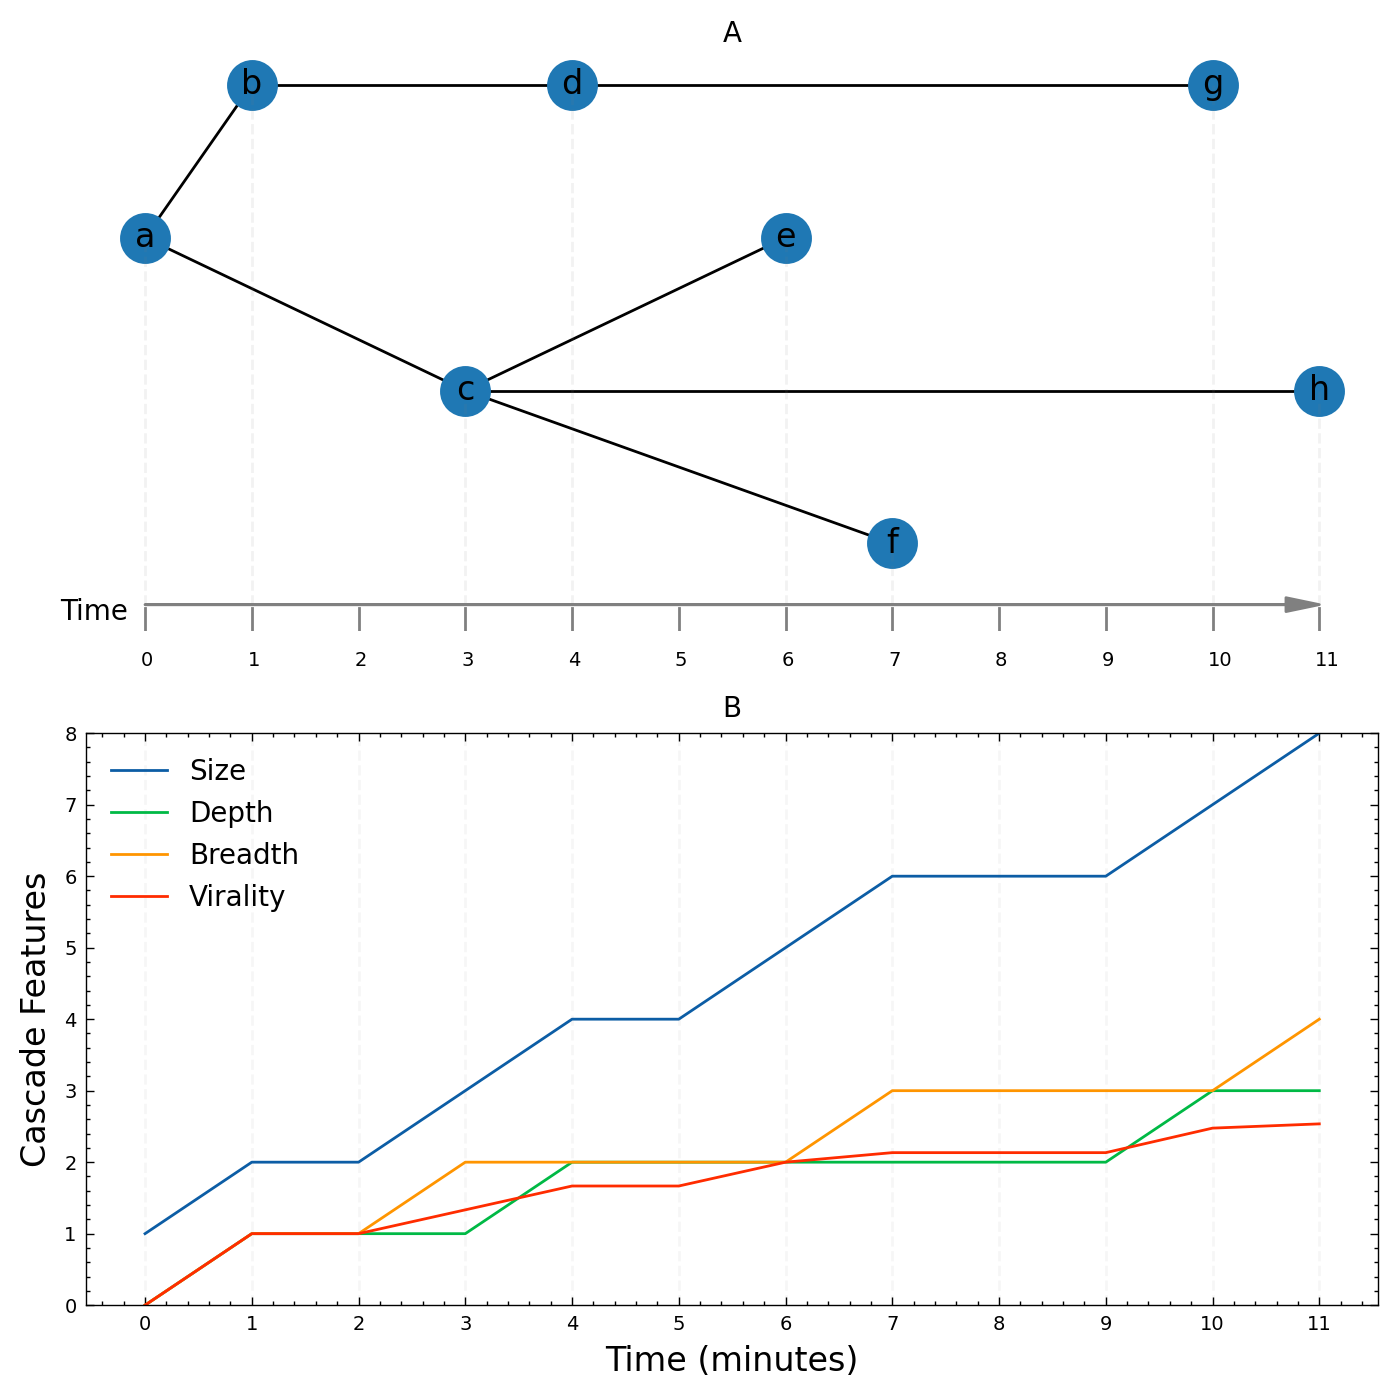

In [6]:
#Figure 2
with plt.style.context(['science','nature', 'no-latex']):
    plt.figure(figsize = [7, 7], dpi = 200)
    plt.subplot(211)
    #plt.title(' a', fontsize = 14)
    nx.draw(g, with_labels = True, pos = pos)
    #plt.xlim([0, 11])
    ymaxi = 0.38
    plt.annotate('', xy=(11, ymaxi), xytext=(0, ymaxi),
             arrowprops=dict(headwidth=5,
                             color='grey', width=0.1))
    
    for i,j in pos.values():
        plt.vlines(x=i, ymin =ymaxi, ymax=j, linewidth=1, linestyle = '--', color='grey', alpha = 0.1)
    for i in range(0, 12):
        plt.axvline(x=i, ymax=0.04, linewidth=1, color='grey')
        plt.text(i-0.04,  0.36, str(i), fontsize = 7)
    plt.text(-0.8, 0.375, "Time", fontsize = 10)    
    # Hide the right and top spines
    plt.title('A', fontsize = 10)
    plt.tight_layout()
   
    plt.subplot(212)
    plt.grid(axis='x',which='major', alpha = 0.1, linewidth=1, linestyle = '--')
    plt.plot(df['t'], df['size'], label = 'Size')
    plt.plot(df['t'], df['depth'], label = 'Depth')
    plt.plot(df['t'], df['breadth'], label = 'Breadth')
    plt.plot(df['t'], df['viralty'], label= 'Virality')
    plt.ylim([0, 8])
    #plt.xlim([0, 11])
    plt.xticks(range(0, 12))
    plt.yticks(range(0, 9))
    plt.legend(fontsize = 10)
    plt.xlabel('Time (minutes)', fontsize = 12)
    plt.ylabel('Cascade Features', fontsize = 12)
    plt.title('B', fontsize = 10)
    #plt.show()
    
    plt.tight_layout()
    #plt.savefig('Figure 2.pdf')

# Figure 3

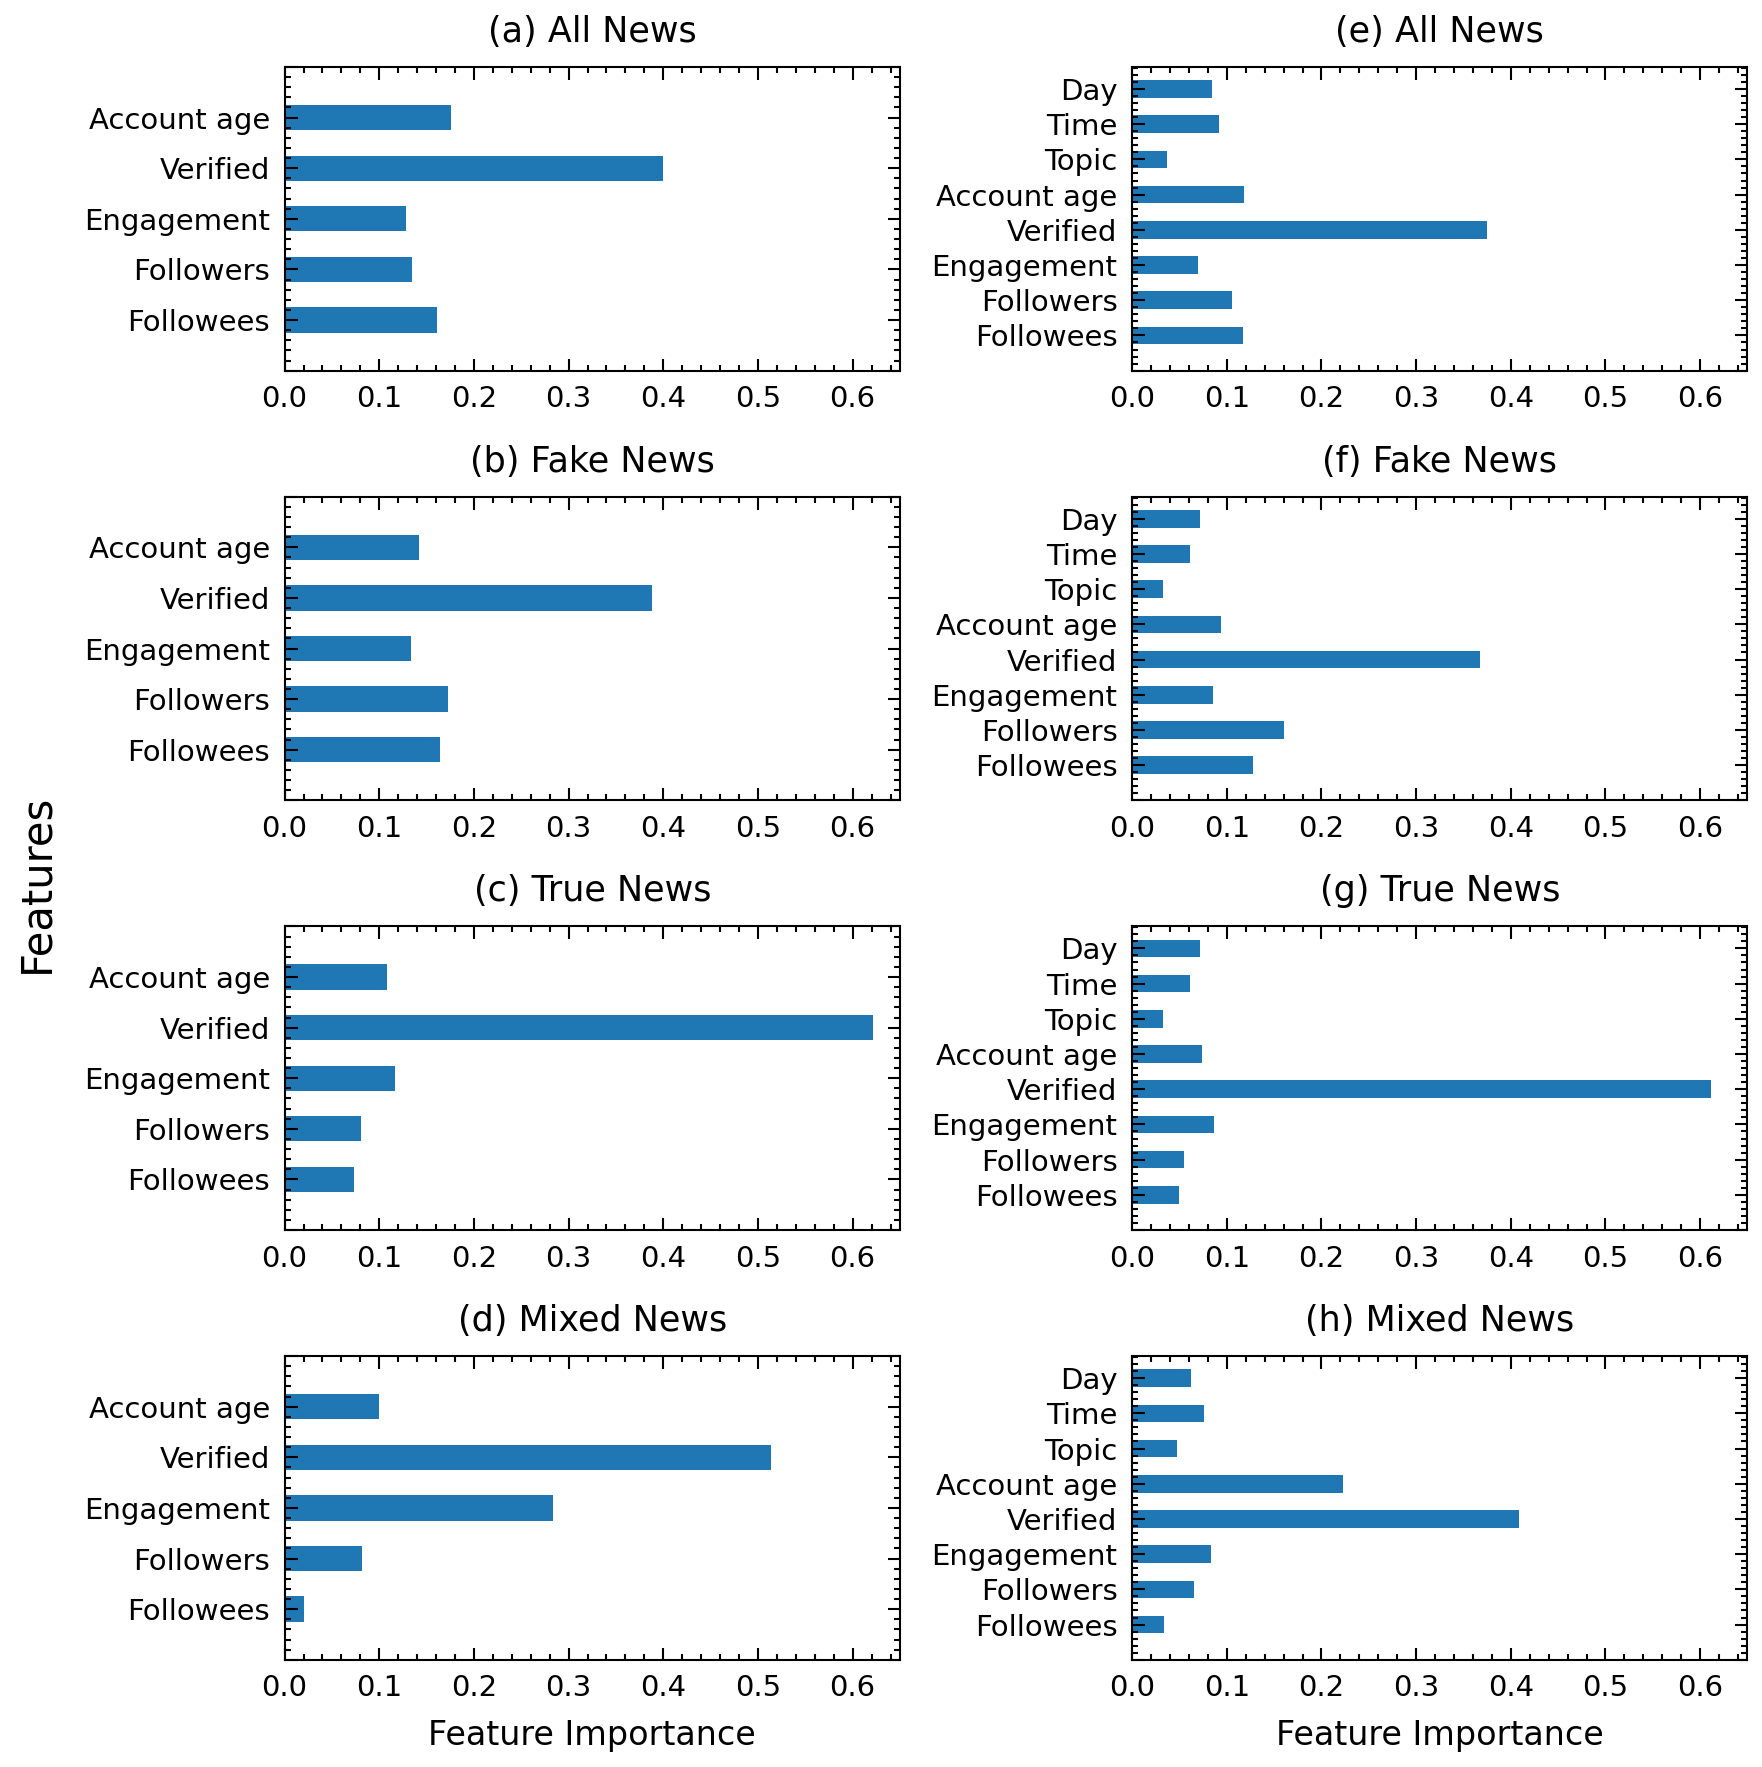

In [132]:
#Figure 3

with plt.style.context(['science','nature', 'no-latex']):
    fig = plt.figure(figsize=(6,6), dpi=300)
    c = 'tab:blue'
    a = 1
# allnews_user&content(model2) feature importance
    ax = fig.add_subplot(422)
    a_uc_topic = 0
    for i in range(5,12):
        a_uc_topic += Model2_FI['allnews'][i]
    a_uc_time = 0
    for i in range(12,18):
        a_uc_time += Model2_FI['allnews'][i]
    a_uc_day = 0
    for i in range(18,25):
        a_uc_day += Model2_FI['allnews'][i]

    plt.barh(1,Model2_FI['allnews'][0],align="center",height=0.5,alpha=a,color = c)
    plt.barh(2,Model2_FI['allnews'][1],align="center",height=0.5,alpha=a,color = c)
    plt.barh(3,Model2_FI['allnews'][2],align="center",height=0.5,alpha=a,color = c)
    plt.barh(4,Model2_FI['allnews'][3],align="center",height=0.5,alpha=a,color = c)
    plt.barh(5,Model2_FI['allnews'][4],align="center",height=0.5,alpha=a,color = c)
    plt.barh(6,a_uc_topic,align="center",height=0.5,alpha=a,color = c)
    plt.barh(7,a_uc_time,align="center",height=0.5,alpha=a,color = c)
    plt.barh(8,a_uc_day,align="center",height=0.5,alpha=a,color = c)
    yticks = ['','Followees','Followers','Engagement','Verified','Account age',
                'Topic','Time','Day']
    ylabels = [i for i in yticks]
    ax.set_yticks(range(len(yticks)))
    ax.set_yticklabels(ylabels)    
    plt.title('(e) All News')
    plt.xlim(0,0.65)
    
 #falsenews_user&content(model2) feature importance
    ax = fig.add_subplot(424)

    f_uc_topic = 0
    for i in range(5,12):
        f_uc_topic += Model2_FI['falsenews'][i]

    f_uc_time = 0
    for i in range(12,18):
        f_uc_time += Model2_FI['falsenews'][i]

    f_uc_day = 0
    for i in range(18,25):
        f_uc_day += Model2_FI['falsenews'][i]
    #plt.yticks([])
    
    plt.barh(1,Model2_FI['falsenews'][0],align="center",height=0.5,alpha=a,color = c)
    plt.barh(2,Model2_FI['falsenews'][1],align="center",height=0.5,alpha=a,color = c)
    plt.barh(3,Model2_FI['falsenews'][2],align="center",height=0.5,alpha=a,color = c)
    plt.barh(4,Model2_FI['falsenews'][3],align="center",height=0.5,alpha=a,color = c)
    plt.barh(5,Model2_FI['falsenews'][4],align="center",height=0.5,alpha=a,color = c)
    plt.barh(6,f_uc_topic,align="center",height=0.5,alpha=a,color = c)
    plt.barh(7,f_uc_time,align="center",height=0.5,alpha=a,color = c)
    plt.barh(8,f_uc_day,align="center",height=0.5,alpha=a,color = c)
    yticks = ['','Followees','Followers','Engagement','Verified','Account age',
                'Topic','Time','Day']
    ylabels = [i for i in yticks]
    ax.set_yticks(range(len(yticks)))
    ax.set_yticklabels(ylabels)
    
    plt.title('(f) Fake News')
    plt.xlim(0,0.65)
    
#truenews_user&content(model2) feature importance
    ax = fig.add_subplot(426)
    t_uc_topic = 0
    for i in range(5,12):
        t_uc_topic += Model2_FI['falsenews'][i]

    t_uc_time = 0
    for i in range(12,18):
        t_uc_time += Model2_FI['falsenews'][i]

    t_uc_day = 0
    for i in range(18,25):
        t_uc_day += Model2_FI['falsenews'][i]

    #plt.yticks([])
    plt.barh(1,Model2_FI['truenews'][0],align="center",height=0.5,alpha=a,color = c)
    plt.barh(2,Model2_FI['truenews'][1],align="center",height=0.5,alpha=a,color = c)
    plt.barh(3,Model2_FI['truenews'][2],align="center",height=0.5,alpha=a,color = c)
    plt.barh(4,Model2_FI['truenews'][3],align="center",height=0.5,alpha=a,color = c)
    plt.barh(5,Model2_FI['truenews'][4],align="center",height=0.5,alpha=a,color = c)
    plt.barh(6,t_uc_topic,align="center",height=0.5,alpha=a,color = c)
    plt.barh(7,t_uc_time,align="center",height=0.5,alpha=a,color = c)
    plt.barh(8,t_uc_day,align="center",height=0.5,alpha=a,color = c)
    
    yticks = ['','Followees','Followers','Engagement','Verified','Account age',
                'Topic','Time','Day']
    ylabels = [i for i in yticks]
    ax.set_yticks(range(len(yticks)))
    ax.set_yticklabels(ylabels)
    
    plt.title('(g) True News')
    plt.xlim(0,0.65)
    
    
 #mixednews_user&content(model2) feature importance
    
    ax = fig.add_subplot(428)
    m_uc_topic = 0
    for i in range(5,12):
        m_uc_topic += Model2_FI['mixednews'][i]

    m_uc_time = 0
    for i in range(12,18):
        m_uc_time += Model2_FI['mixednews'][i]

    m_uc_day = 0
    for i in range(18,25):
        m_uc_day += Model2_FI['mixednews'][i]

    plt.barh(1,Model2_FI['mixednews'][0],align="center",height=0.5,alpha=a,color = c)
    plt.barh(2,Model2_FI['mixednews'][1],align="center",height=0.5,alpha=a,color = c)
    plt.barh(3,Model2_FI['mixednews'][2],align="center",height=0.5,alpha=a,color = c)
    plt.barh(4,Model2_FI['mixednews'][3],align="center",height=0.5,alpha=a,color = c)
    plt.barh(5,Model2_FI['mixednews'][4],align="center",height=0.5,alpha=a,color = c)
    plt.barh(6,m_uc_topic,align="center",height=0.5,alpha=a,color = c)
    plt.barh(7,m_uc_time,align="center",height=0.5,alpha=a,color = c)
    plt.barh(8,m_uc_day,align="center",height=0.5,alpha=a,color = c)
    yticks = ['','Followees','Followers','Engagement','Verified','Account age',
                'Topic','Time','Day']
    ylabels = [i for i in yticks]
    ax.set_yticks(range(len(yticks)))
    ax.set_yticklabels(ylabels)
    plt.xlabel('Feature Importance',fontsize = 8)
    plt.title('(h) Mixed News')
    plt.xlim(0,0.65)
    #plt.yticks([])
    
#allnews_user_features(model1) feature importance

    ax = fig.add_subplot(421)

    plt.barh(1,Model1_FI['allnews'][0],align="center",height=0.5,alpha=a,color = c)
    plt.barh(2,Model1_FI['allnews'][1],align="center",height=0.5,alpha=a,color = c)
    plt.barh(3,Model1_FI['allnews'][2],align="center",height=0.5,alpha=a,color = c)
    plt.barh(4,Model1_FI['allnews'][3],align="center",height=0.5,alpha=a,color = c)
    plt.barh(5,Model1_FI['allnews'][4],align="center",height=0.5,alpha=a,color = c)
   # plt.yticks([]) 
    yticks = ['','Followees','Followers','Engagement','Verified','Account age','']
    ylabels = [i for i in yticks]
    ax.set_yticks(range(len(yticks)))
    ax.set_yticklabels(ylabels)
    plt.title('(a) All News')
    plt.xlim(0,0.65)
    
#fakenews_user_features(model1) feature importance
    ax = fig.add_subplot(423)
    plt.barh(1,Model1_FI['falsenews'][0],align="center",height=0.5,alpha=a,color = c)
    plt.barh(2,Model1_FI['falsenews'][1],align="center",height=0.5,alpha=a,color = c)
    plt.barh(3,Model1_FI['falsenews'][2],align="center",height=0.5,alpha=a,color = c)
    plt.barh(4,Model1_FI['falsenews'][3],align="center",height=0.5,alpha=a,color = c)
    plt.barh(5,Model1_FI['falsenews'][4],align="center",height=0.5,alpha=a,color = c)
    #plt.yticks([])   
    yticks = ['','Followees','Followers','Engagement','Verified','Account age','']
    ylabels = [i for i in yticks]
    ax.set_yticks(range(len(yticks)))
    ax.set_yticklabels(ylabels)
    plt.title('(b) Fake News')
    plt.xlim(0,0.65)



    
#truenews_user_features(model1) feature importance
    ax = fig.add_subplot(425)
    plt.barh(1,Model1_FI['truenews'][0],align="center",height=0.5,alpha=a,color = c)
    plt.barh(2,Model1_FI['truenews'][1],align="center",height=0.5,alpha=a,color = c)
    plt.barh(3,Model1_FI['truenews'][2],align="center",height=0.5,alpha=a,color = c)
    plt.barh(4,Model1_FI['truenews'][3],align="center",height=0.5,alpha=a,color = c)
    plt.barh(5,Model1_FI['truenews'][4],align="center",height=0.5,alpha=a,color = c)
    #plt.yticks([])    
    yticks = ['','Followees','Followers','Engagement','Verified','Account age','']
    ylabels = [i for i in yticks]
    ax.set_yticks(range(len(yticks)))
    ax.set_yticklabels(ylabels)
    plt.title('(c) True News')
    plt.xlim(0,0.65)

    
#mixednews_user_features(model1) feature importance
    ax = fig.add_subplot(427)
    plt.barh(1,Model1_FI['mixednews'][0],align="center",height=0.5,alpha=a,color = c)
    plt.barh(2,Model1_FI['mixednews'][1],align="center",height=0.5,alpha=a,color = c)
    plt.barh(3,Model1_FI['mixednews'][2],align="center",height=0.5,alpha=a,color = c)
    plt.barh(4,Model1_FI['mixednews'][3],align="center",height=0.5,alpha=a,color = c)
    plt.barh(5,Model1_FI['mixednews'][4],align="center",height=0.5,alpha=a,color = c)
    #plt.yticks([])
    yticks = ['','Followees','Followers','Engagement','Verified','Account age','']
    ylabels = [i for i in yticks]
    ax.set_yticks(range(len(yticks)))
    ax.set_yticklabels(ylabels)
    plt.title('(d) Mixed News')
    plt.xlim(0,0.65)
    plt.xlabel('Feature Importance',fontsize = 8)
    

    fig.supylabel('Features',fontsize = 10)

    fig.subplots_adjust(right=0.8)   

    plt.tight_layout()
    plt.savefig('Figure 3.pdf', bbox_inches='tight',dpi = 600)
    plt.show()

# Figure 4

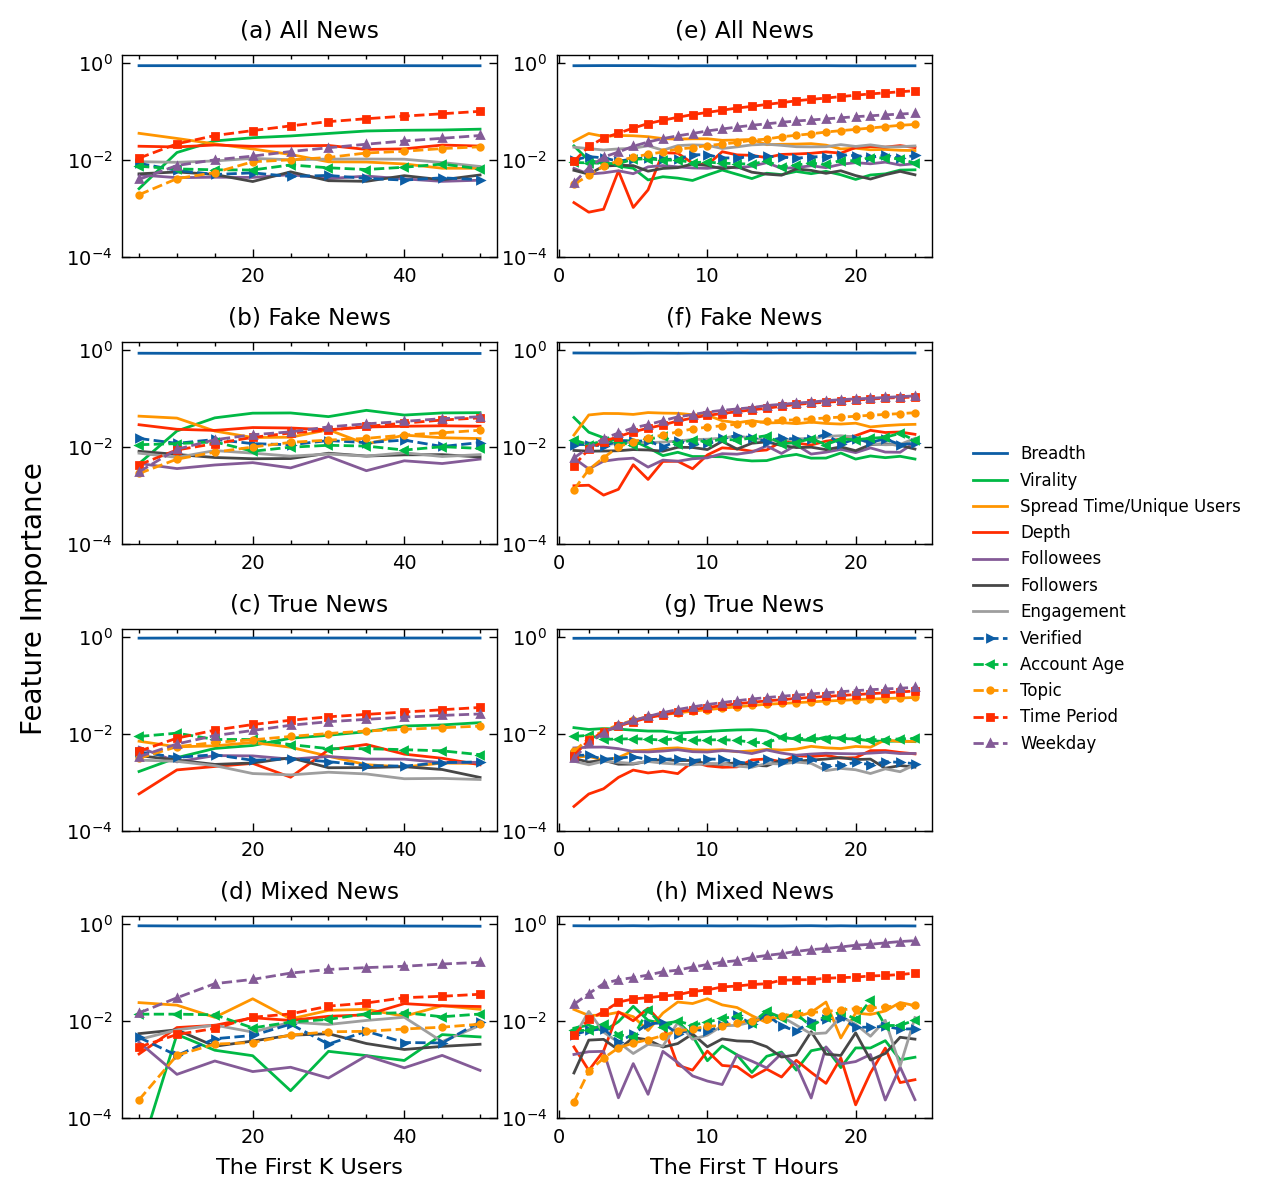

In [126]:
#Figure 4
with plt.style.context(['science', 'nature', 'no-latex']):
    fig = plt.figure(figsize=(6,6), dpi=200)
    marker = 2
    #all news_k_feature_importance
    plt.subplot(421)
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['all_Breadth'])
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['all_Virality'])
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['all_Spread Time'])
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['all_Depth'])
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['all_Followees'])
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['all_Followers'])
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['all_Engagement'])
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['all_Verified'],ls = '--', marker = '>', markersize = marker)
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['all_Account Age'],ls = '--', marker = '<', markersize = marker)
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['all_Topic'], ls = '--', marker = 'o', markersize = marker)
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['all_Time Period'], ls = '--', marker = 's', markersize = marker)
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['all_Weekday'], ls = '--', marker = '^', markersize = marker)
    plt.yscale('log')
    plt.title('(a) All News')
    plt.ylim([0.0001, 1.5])
    
    #false news_k_feature_importance
   
    plt.subplot(423)
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['false_Breadth'])
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['false_Virality'])
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['false_Spread Time'])
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['false_Depth'])
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['false_Followees'])
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['false_Followers'])
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['false_Engagement'])
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['false_Verified'],ls = '--', marker = '>', markersize = marker)
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['false_Account Age'],ls = '--', marker = '<', markersize = marker)
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['false_Topic'], ls = '--', marker = 'o', markersize = marker)
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['false_Time Period'], ls = '--', marker = 's', markersize = marker)
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['false_Weekday'], ls = '--', marker = '^', markersize = marker)
    plt.title('(b) Fake News')
    plt.yscale('log')
    plt.ylim([0.0001, 1.5])
    
    #true news_k_feature_importance
    
    plt.subplot(425)
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['true_Breadth'])
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['true_Virality'])
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['true_Spread Time'])
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['true_Depth'])
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['true_Followees'])
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['true_Followers'])
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['true_Engagement'])
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['true_Verified'],ls = '--', marker = '>', markersize = marker)
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['true_Account Age'],ls = '--', marker = '<', markersize = marker)
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['true_Topic'], ls = '--', marker = 'o', markersize = marker)
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['true_Time Period'], ls = '--', marker = 's', markersize = marker)
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['true_Weekday'], ls = '--', marker = '^', markersize = marker)

    plt.title('(c) True News')
    plt.yscale('log')
    plt.ylim([0.0001, 1.5])
    
    #mixed news_k_feature_importance

    plt.subplot(427)
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['mixed_Breadth'])
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['mixed_Virality'])
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['mixed_Spread Time'])
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['mixed_Depth'])
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['mixed_Followees'])
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['mixed_Followers'])
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['mixed_Engagement'])
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['mixed_Verified'],ls = '--', marker = '>', markersize = marker)
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['mixed_Account Age'],ls = '--', marker = '<', markersize = marker)
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['mixed_Topic'], ls = '--', marker = 'o', markersize = marker)
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['mixed_Time Period'], ls = '--', marker = 's', markersize = marker)
    plt.plot([5,10,15,20,25,30,35,40,45,50],Model3_k_df['mixed_Weekday'], ls = '--', marker = '^', markersize = marker)
    plt.title('(d) Mixed News')
    plt.xlabel('The First K Users',fontsize = 8)
    plt.yscale('log')
    plt.ylim([0.0001, 1.5])
    
    #all news_t_feature_importance
    plt.subplot(422)
    plt.plot(range(1,25),Model3_t_df['all_Breadth'])
    plt.plot(range(1,25),Model3_t_df['all_Virality'])
    plt.plot(range(1,25),Model3_t_df['all_Unique User'])
    plt.plot(range(1,25),Model3_t_df['all_Depth'])
    plt.plot(range(1,25),Model3_t_df['all_Followees'])
    plt.plot(range(1,25),Model3_t_df['all_Followers'])
    plt.plot(range(1,25),Model3_t_df['all_Engagement'])
    plt.plot(range(1,25),Model3_t_df['all_Verified'],ls = '--', marker = '>', markersize = marker)
    plt.plot(range(1,25),Model3_t_df['all_Account Age'],ls = '--', marker = '<', markersize = marker)
    plt.plot(range(1,25),Model3_t_df['all_Topic'], ls = '--', marker = 'o', markersize = marker)
    plt.plot(range(1,25),Model3_t_df['all_Time Period'], ls = '--', marker = 's', markersize = marker)
    plt.plot(range(1,25),Model3_t_df['all_Weekday'], ls = '--', marker = '^', markersize = marker)

    plt.title('(e) All News')
    plt.yscale('log')
    plt.ylim([0.0001, 1.5])

    #false news_t_feature_importance
    
    plt.subplot(424)
    plt.plot(range(1,25),Model3_t_df['false_Breadth'])
    plt.plot(range(1,25),Model3_t_df['false_Virality'])
    plt.plot(range(1,25),Model3_t_df['false_Unique User'])
    plt.plot(range(1,25),Model3_t_df['false_Depth'])
    plt.plot(range(1,25),Model3_t_df['false_Followees'])
    plt.plot(range(1,25),Model3_t_df['false_Followers'])
    plt.plot(range(1,25),Model3_t_df['false_Engagement'])
    plt.plot(range(1,25),Model3_t_df['false_Verified'],ls = '--', marker = '>', markersize = marker)
    plt.plot(range(1,25),Model3_t_df['false_Account Age'],ls = '--', marker = '<', markersize = marker)
    plt.plot(range(1,25),Model3_t_df['false_Topic'], ls = '--', marker = 'o', markersize = marker)
    plt.plot(range(1,25),Model3_t_df['false_Time Period'], ls = '--', marker = 's', markersize = marker)
    plt.plot(range(1,25),Model3_t_df['false_Weekday'], ls = '--', marker = '^', markersize = marker)

    plt.title('(f) Fake News')
    plt.yscale('log')
    plt.ylim([0.0001, 1.5])

    
    #true news_t_feature_importance
    plt.subplot(426)
    plt.plot(range(1,25),Model3_t_df['true_Breadth'])
    plt.plot(range(1,25),Model3_t_df['true_Virality'])
    plt.plot(range(1,25),Model3_t_df['true_Unique User'])
    plt.plot(range(1,25),Model3_t_df['true_Depth'])
    plt.plot(range(1,25),Model3_t_df['true_Followees'])
    plt.plot(range(1,25),Model3_t_df['true_Followers'])
    plt.plot(range(1,25),Model3_t_df['true_Engagement'])
    plt.plot(range(1,25),Model3_t_df['true_Verified'],ls = '--', marker = '>', markersize = marker)
    plt.plot(range(1,25),Model3_t_df['true_Account Age'],ls = '--', marker = '<', markersize = marker)
    plt.plot(range(1,25),Model3_t_df['true_Topic'], ls = '--', marker = 'o', markersize = marker)
    plt.plot(range(1,25),Model3_t_df['true_Time Period'], ls = '--', marker = 's', markersize = marker)
    plt.plot(range(1,25),Model3_t_df['true_Weekday'], ls = '--', marker = '^', markersize = marker)
    plt.title('(g) True News')
    plt.yscale('log')
    plt.ylim([0.0001, 1.5])

    #mixed news_t_feature_importance    
    plt.subplot(428)
    plt.plot(range(1,25),Model3_t_df['mixed_Breadth'])
    plt.plot(range(1,25),Model3_t_df['mixed_Virality'])
    plt.plot(range(1,25),Model3_t_df['mixed_Unique User'])
    plt.plot(range(1,25),Model3_t_df['mixed_Depth'])
    plt.plot(range(1,25),Model3_t_df['mixed_Followees'])
    plt.plot(range(1,25),Model3_t_df['mixed_Followers'])
    plt.plot(range(1,25),Model3_t_df['mixed_Engagement'])
    plt.plot(range(1,25),Model3_t_df['mixed_Verified'],ls = '--', marker = '>', markersize = marker)
    plt.plot(range(1,25),Model3_t_df['mixed_Account Age'],ls = '--', marker = '<', markersize = marker)
    plt.plot(range(1,25),Model3_t_df['mixed_Topic'], ls = '--', marker = 'o', markersize = marker)
    plt.plot(range(1,25),Model3_t_df['mixed_Time Period'], ls = '--', marker = 's', markersize = marker)
    plt.plot(range(1,25),Model3_t_df['mixed_Weekday'], ls = '--', marker = '^', markersize = marker)
    plt.title('(h) Mixed News')
    plt.yscale('log')
    plt.ylim([0.0001, 1.5])

    plt.xlabel('The First T Hours', fontsize = 8)
    
    #fig.supxlabel('fig.supxlabel')
    fig.supylabel('Feature Importance',fontsize = 10)
    fig.legend(['Breadth','Virality','Spread Time/Unique Users','Depth',
                'Followees','Followers','Engagement','Verified',
                'Account Age','Topic','Time Period','Weekday'], 
               loc= 'center right',
               bbox_to_anchor=(1.05,0.5),
               fontsize = 6)
 
    
    plt.tight_layout()
    fig.subplots_adjust(right=0.78) 
    plt.savefig('Figure 4.pdf', bbox_inches="tight",dpi = 600)

# Figure 6

In [73]:
Compare_K,Compare_T

(  Unnamed: 0   allnews  fakenews  truenews  mixednews
 0     bakshy  0.333075  0.393436  0.541264   0.153906
 1     lerman  0.332975  0.393436  0.541264   0.153906
 2     romero  0.333350  0.385225  0.544843   0.103717
 3    shulman  0.336376  0.389657  0.552264   0.022155,
   Unnamed: 0   allnews  fakenews  truenews  mixednews
 0     bakshy  0.516549  0.411530  0.790644   0.481106
 1     lerman  0.516642  0.356011  0.797162   0.498409
 2     romero  0.511275  0.421314  0.791132   0.484907
 3    shulman  0.515648  0.415959  0.795641   0.486098)

In [78]:
Compare_K['allnews'][0]

0.3330748602853421

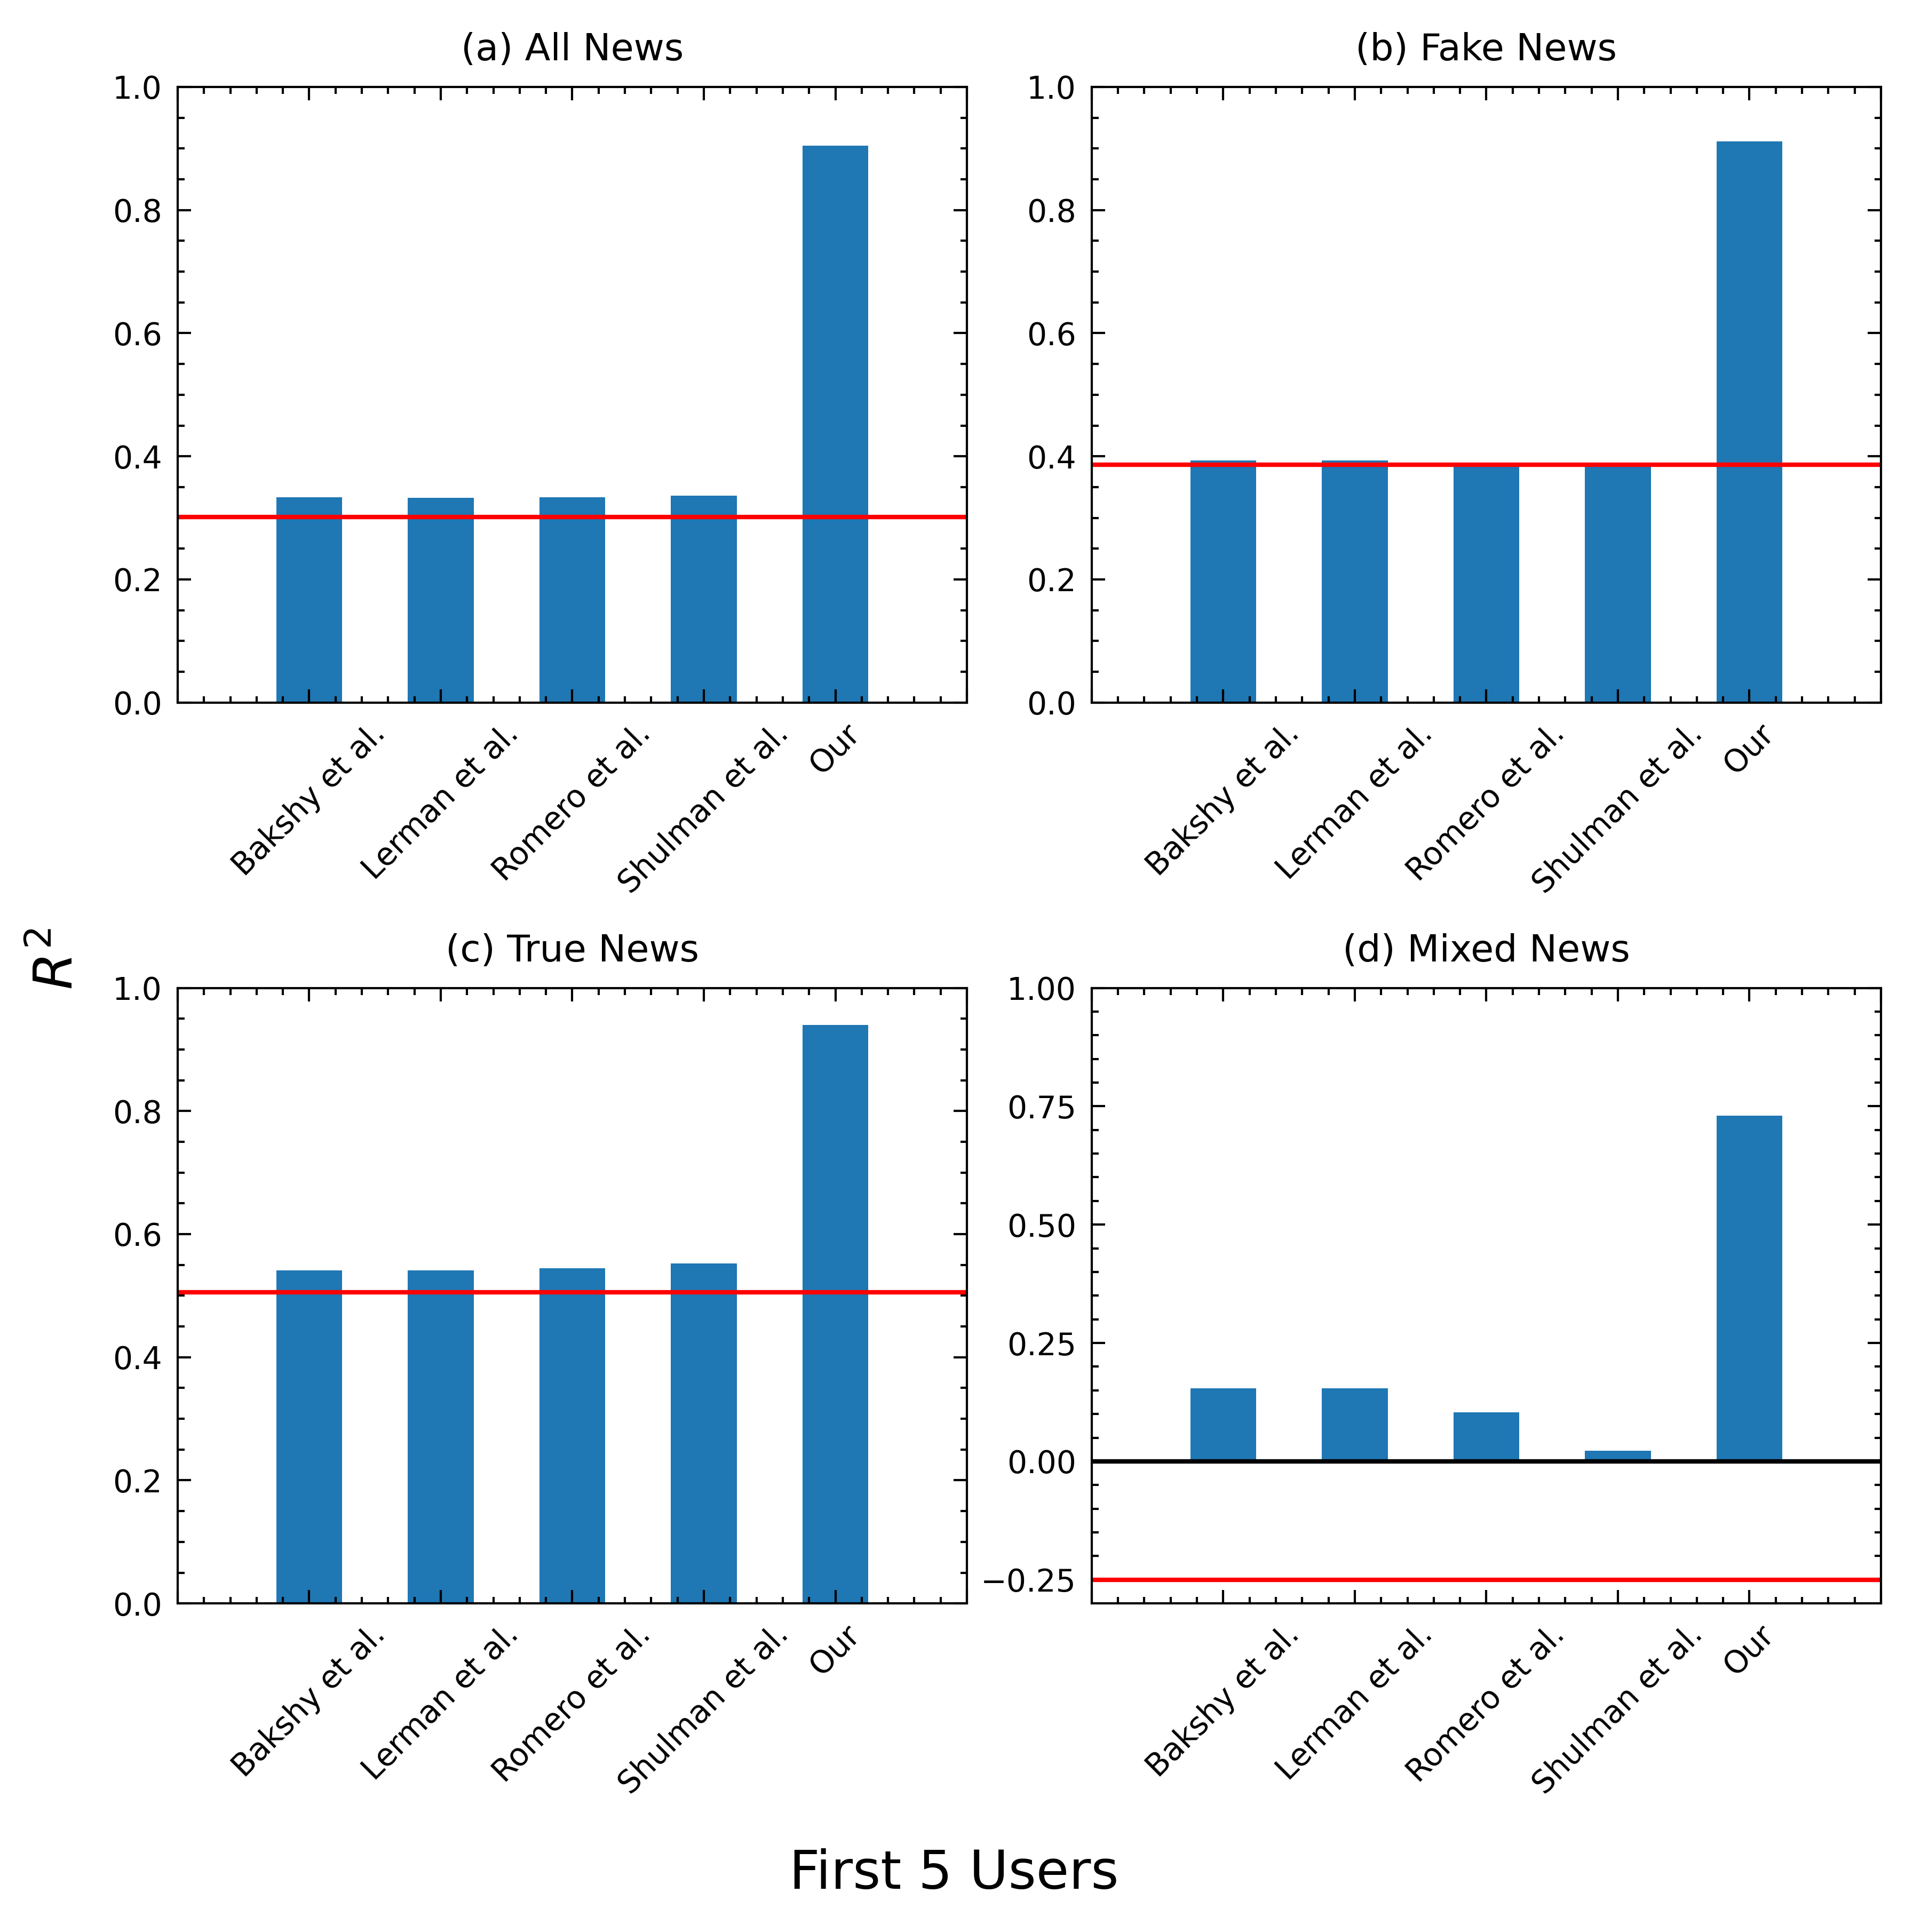

In [127]:
import numpy as np
import matplotlib.pyplot as plt  
with plt.style.context(['science', 'nature', 'no-latex']):
    fig = plt.figure(figsize=(6,6), dpi=600)
    c = 'tab:blue'
    rfmodel2_allnews = 0.3013324563408143
    rfmodel2_falsenews = 0.38669265305551825
    rfmodel2_truenews = 0.5057115029276376
    rfmodel2_mixednews = -0.24993165900638648
    x = [1,2,3,4,5]
    
    ax = fig.add_subplot(221)   
    plt.axhline(y = rfmodel2_allnews, color='r', linestyle='-')    
    plt.bar(x,Compare_K['allnews'],width = 0.5,color = c)
    xticks = ['','Bakshy et al.','Lerman et al.',
              'Romero et al.','Shulman et al.',
              'Our','']
    xlabels = [i for i in xticks]
    ax.set_xticks(range(len(xticks)))
    ax.set_xticklabels(xlabels,rotation=45)
    plt.title('(a) All News')
    plt.ylim(0,1)
    
    ax = fig.add_subplot(222)   
    
    plt.axhline(y = rfmodel2_falsenews, color='r', linestyle='-')    
    plt.bar(x,Compare_K['falsenews'],width = 0.5,color = c)
    xticks = ['','Bakshy et al.','Lerman et al.',
              'Romero et al.','Shulman et al.',
              'Our','']
    xlabels = [i for i in xticks]
    ax.set_xticks(range(len(xticks)))
    ax.set_xticklabels(xlabels,rotation=45)
    plt.title('(b) Fake News')
    plt.ylim(0,1)

    ax = fig.add_subplot(223)   
    plt.axhline(y = rfmodel2_truenews, color='r', linestyle='-')    
    plt.bar(x,Compare_K['truenews'],width = 0.5,color = c)
    xticks = ['','Bakshy et al.','Lerman et al.',
              'Romero et al.','Shulman et al.',
              'Our','']
    xlabels = [i for i in xticks]
    ax.set_xticks(range(len(xticks)))
    ax.set_xticklabels(xlabels,rotation=45)
    plt.title('(c) True News')
    plt.ylim(0,1)
    
    ax = fig.add_subplot(224)   
    plt.axhline(y = rfmodel2_mixednews, color='r', linestyle='-')  
    plt.axhline(y = 0, color='black', linestyle='-')        
    plt.bar(x,Compare_K['mixednews'],width = 0.5,color = c)
    xticks = ['','Bakshy et al.','Lerman et al.',
              'Romero et al.','Shulman et al.',
              'Our','']
    xlabels = [i for i in xticks]
    ax.set_xticks(range(len(xticks)))
    ax.set_xticklabels(xlabels,rotation=45)
    plt.title('(d) Mixed News')
    plt.ylim(-0.3,1)
    fig.supylabel('$R^2$',fontsize = 12)

    fig.supxlabel('First 5 Users', fontsize = 12)
    plt.tight_layout()
    plt.savefig('Figure 6.pdf',bbox_inches="tight")    

# Figure 7

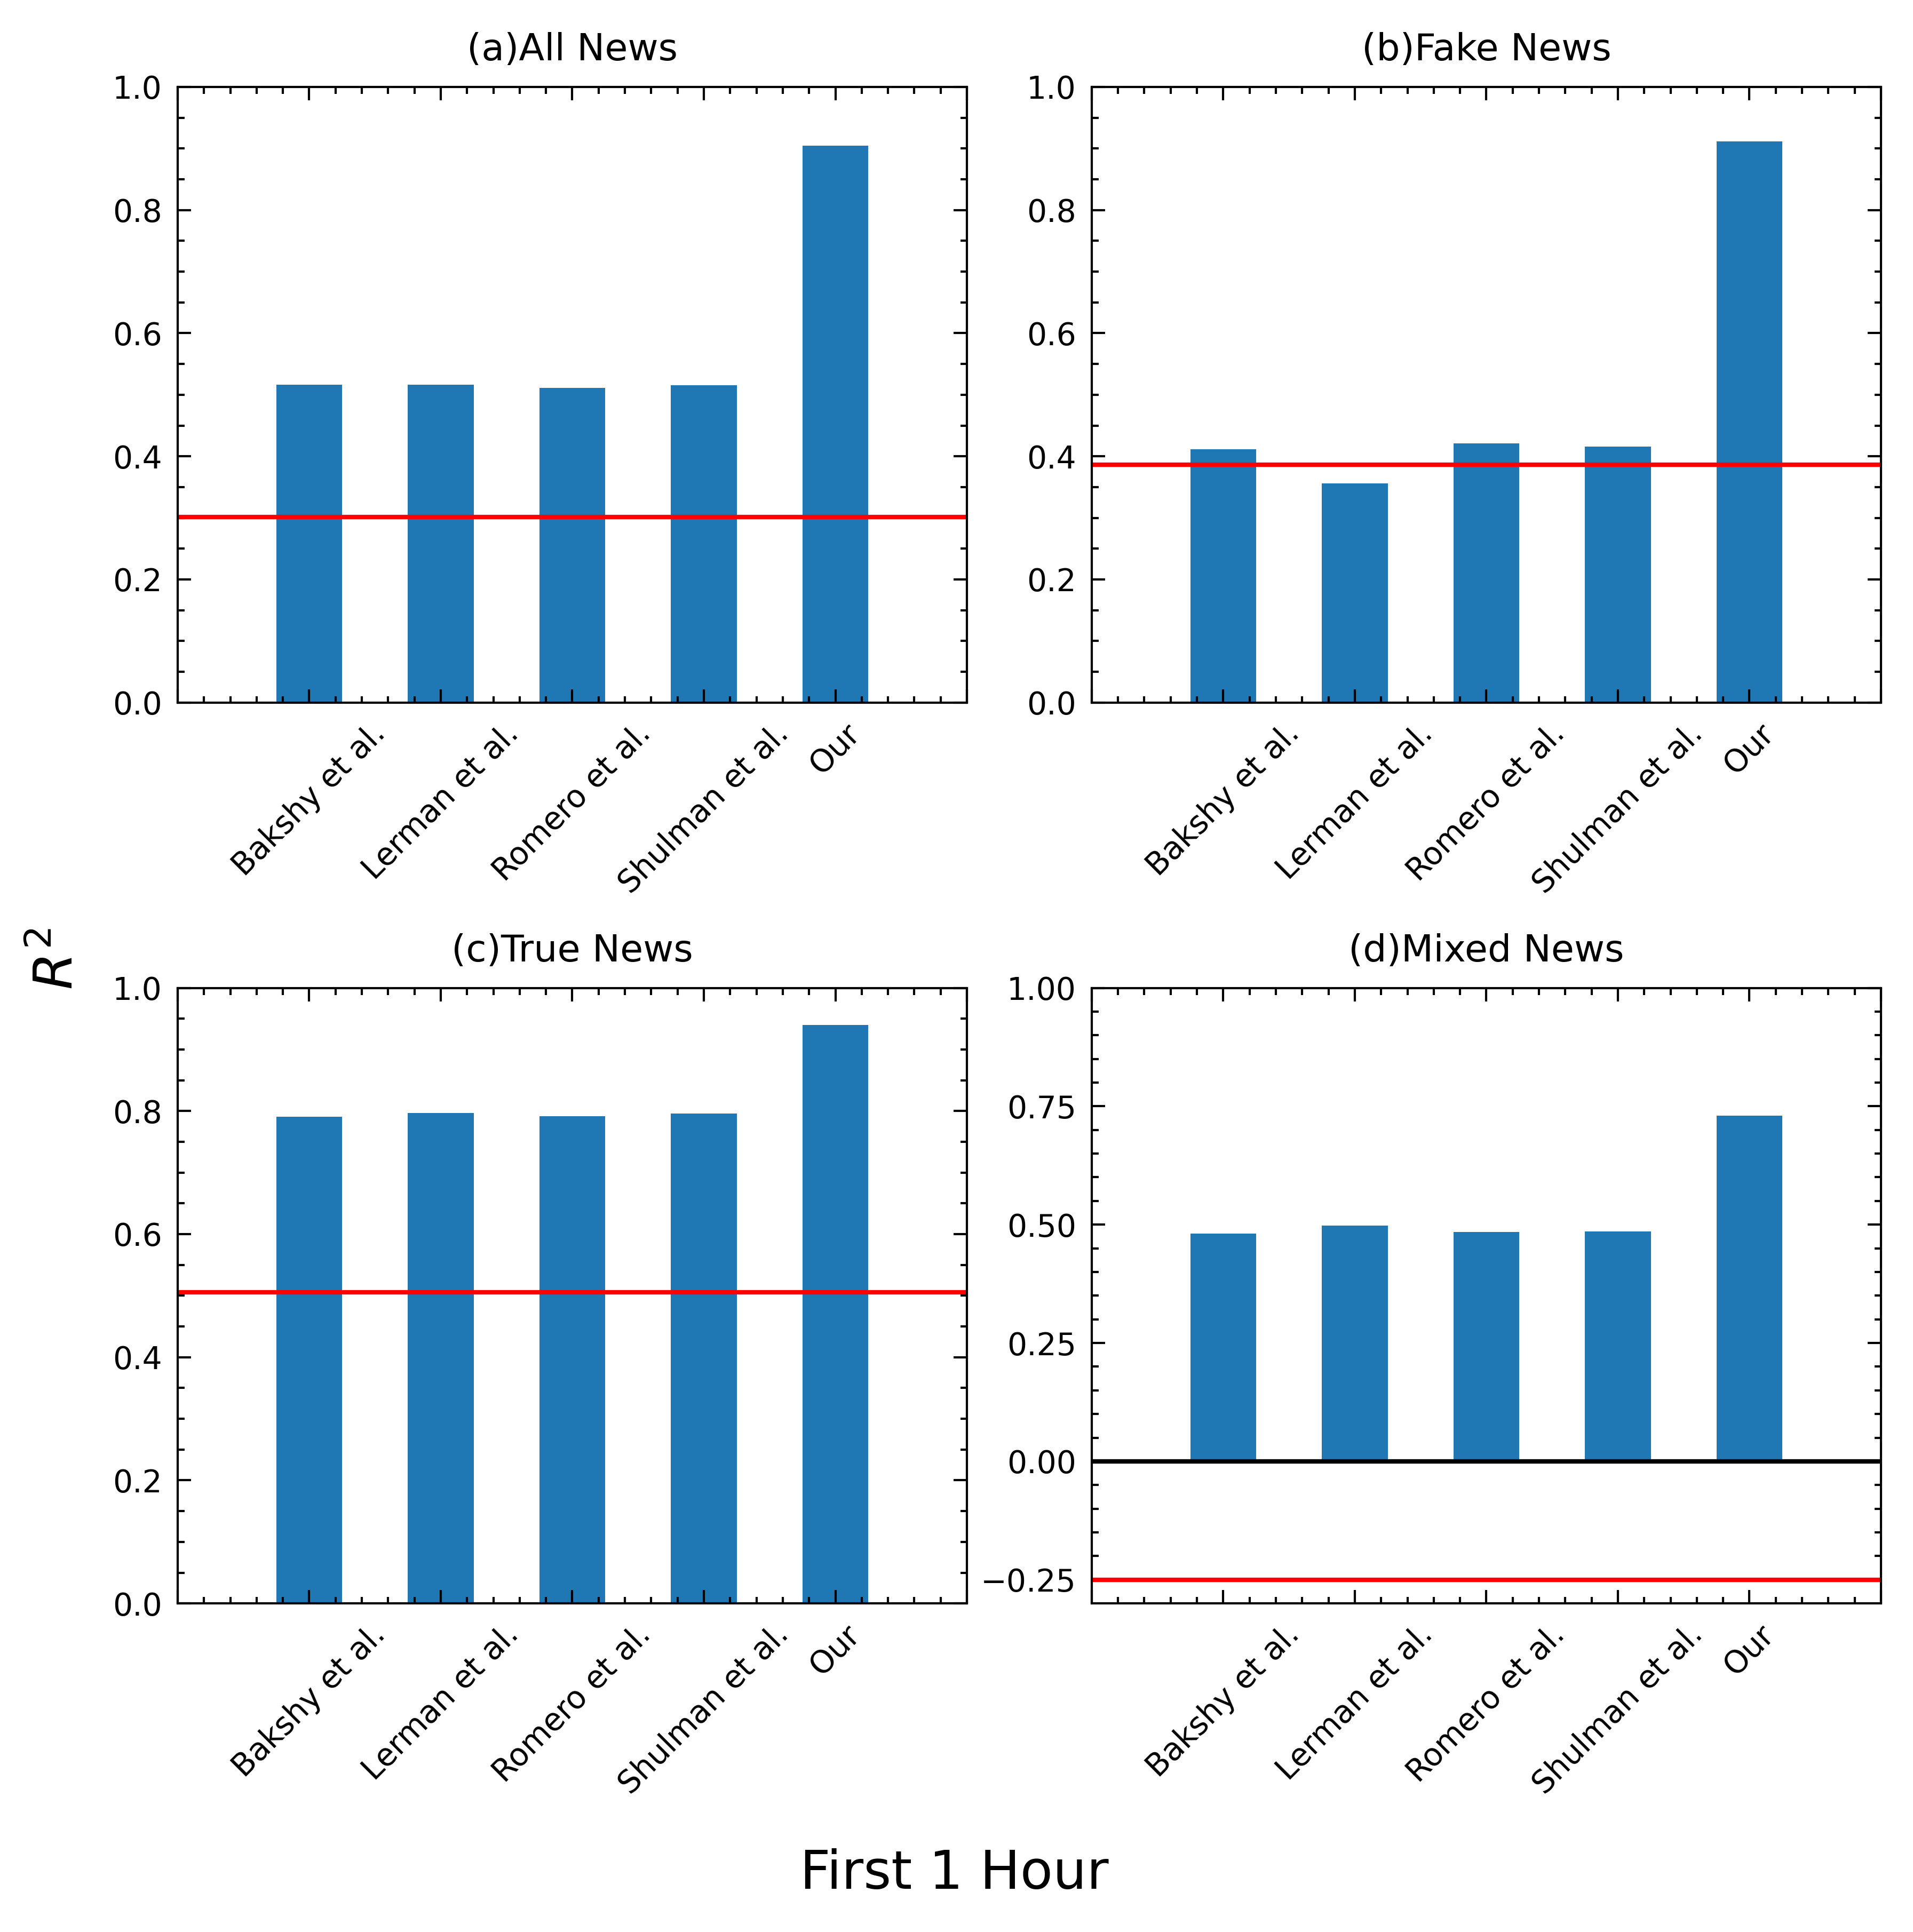

In [129]:
import numpy as np
import matplotlib.pyplot as plt  
with plt.style.context(['science', 'nature', 'no-latex']):
    fig = plt.figure(figsize=(6,6), dpi=600)
    c = 'tab:blue'
    rfmodel2_allnews = 0.3013324563408143
    rfmodel2_falsenews = 0.38669265305551825
    rfmodel2_truenews = 0.5057115029276376
    rfmodel2_mixednews = -0.24993165900638648
    x = [1,2,3,4,5]
    ax = fig.add_subplot(221)   
    plt.axhline(y = rfmodel2_allnews, color='r', linestyle='-')    
    plt.bar(x,Compare_T['allnews'], width=0.5, color = c)
    xticks = ['','Bakshy et al.','Lerman et al.',
              'Romero et al.','Shulman et al.',
              'Our','']
    xlabels = [i for i in xticks]
    ax.set_xticks(range(len(xticks)))
    ax.set_xticklabels(xlabels,rotation=45)
    plt.title('(a)All News')
    plt.ylim(0,1)
    
    ax = fig.add_subplot(222)   
    plt.axhline(y = rfmodel2_falsenews, color='r', linestyle='-')    
    plt.bar(x,Compare_T['falsenews'], width=0.5, color = c)
    xticks = ['','Bakshy et al.','Lerman et al.',
              'Romero et al.','Shulman et al.',
              'Our','']
    xlabels = [i for i in xticks]
    ax.set_xticks(range(len(xticks)))
    ax.set_xticklabels(xlabels,rotation=45)
    plt.title('(b)Fake News')
    plt.ylim(0,1)

    ax = fig.add_subplot(223)   
    plt.axhline(y = rfmodel2_truenews, color='r', linestyle='-')    
    plt.bar(x,Compare_T['truenews'], width=0.5, color = c)

    xticks = ['','Bakshy et al.','Lerman et al.',
              'Romero et al.','Shulman et al.',
              'Our','']
    xlabels = [i for i in xticks]
    ax.set_xticks(range(len(xticks)))
    ax.set_xticklabels(xlabels,rotation=45)
    plt.title('(c)True News')
    plt.ylim(0,1)
    
    ax = fig.add_subplot(224)   
    plt.axhline(y = rfmodel2_mixednews, color='r', linestyle='-')   
    plt.axhline(y = 0, color='black', linestyle='-')    
    plt.bar(x,Compare_T['mixednews'], width=0.5, color = c)
    xticks = ['','Bakshy et al.','Lerman et al.',
              'Romero et al.','Shulman et al.',
              'Our','']
    xlabels = [i for i in xticks]
    ax.set_xticks(range(len(xticks)))
    ax.set_xticklabels(xlabels,rotation=45)
    plt.title('(d)Mixed News')
    plt.ylim(-0.3,1)

    fig.supylabel('$R^2$', fontsize = 12)
    fig.supxlabel('First 1 Hour', fontsize = 12)
    plt.tight_layout()


    plt.savefig('Figure 7.pdf',bbox_inches="tight")  

# Figure 8

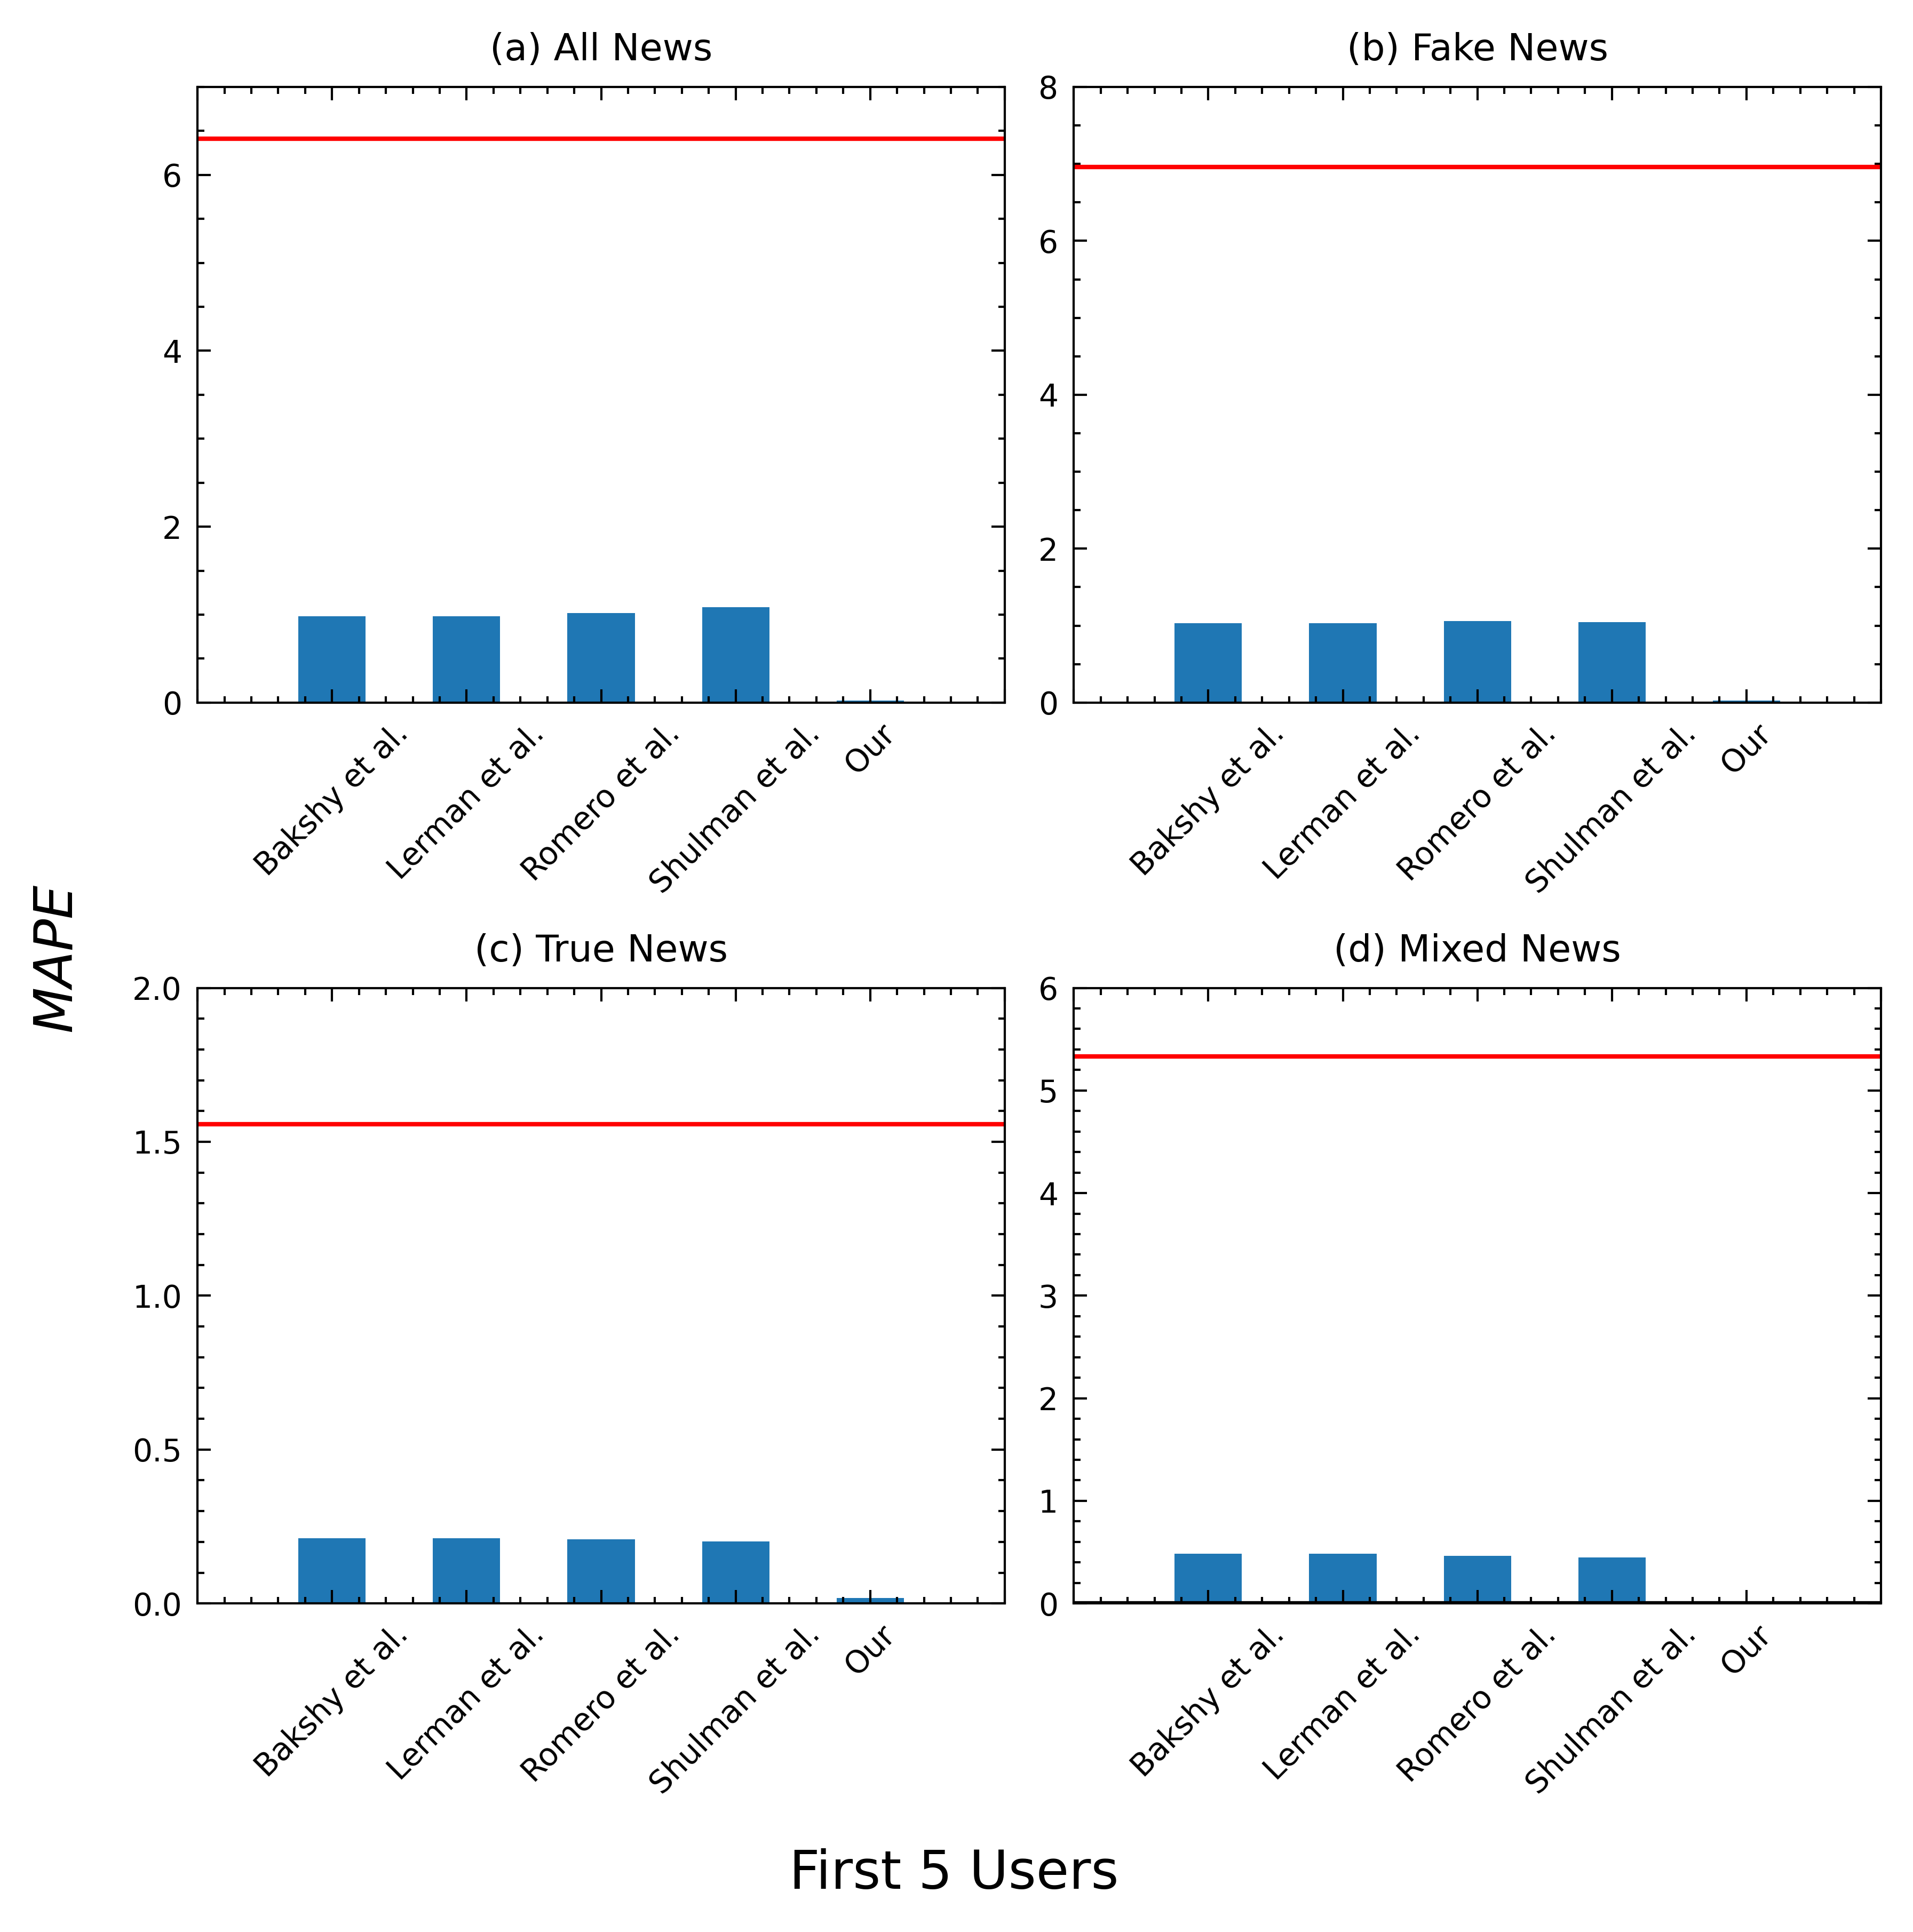

In [130]:
import numpy as np
import matplotlib.pyplot as plt  
with plt.style.context(['science', 'nature', 'no-latex']):
    fig = plt.figure(figsize=(6,6), dpi=600)
    c = 'tab:blue'
    rfmodel2_allnews = 6.410139399480783
    rfmodel2_falsenews = 6.958432661610942
    rfmodel2_truenews = 1.5563254470329588
    rfmodel2_mixednews = 5.329460449930295
    x = [1,2,3,4,5]
    
    ax = fig.add_subplot(221)   
    plt.axhline(y = rfmodel2_allnews, color='r', linestyle='-')    
    plt.bar(x,Compare_K_MAPE['allnews'],width = 0.5,color = c)
    xticks = ['','Bakshy et al.','Lerman et al.',
              'Romero et al.','Shulman et al.',
              'Our','']

    xlabels = [i for i in xticks]
    ax.set_xticks(range(len(xticks)))

    ax.set_xticklabels(xlabels,rotation=45)

    plt.title('(a) All News')
    plt.ylim(0,7)
    
    ax = fig.add_subplot(222)   
    
    plt.axhline(y = rfmodel2_falsenews, color='r', linestyle='-')    
    plt.bar(x,Compare_K_MAPE['falsenews'],width = 0.5,color = c)
    xticks = ['','Bakshy et al.','Lerman et al.',
              'Romero et al.','Shulman et al.',
              'Our','']
    xlabels = [i for i in xticks]
    ax.set_xticks(range(len(xticks)))

    ax.set_xticklabels(xlabels,rotation=45)
    plt.title('(b) Fake News')
    plt.ylim(0,8)

    ax = fig.add_subplot(223)   
    plt.axhline(y = rfmodel2_truenews, color='r', linestyle='-')    
    plt.bar(x,Compare_K_MAPE['truenews'],width = 0.5,color = c)
    xticks = ['','Bakshy et al.','Lerman et al.',
              'Romero et al.','Shulman et al.',
              'Our','']
    xlabels = [i for i in xticks]
    ax.set_xticks(range(len(xticks)))
    ax.set_xticklabels(xlabels,rotation=45)
    plt.title('(c) True News')
    plt.ylim(0,2)
    
    ax = fig.add_subplot(224)   
    plt.axhline(y = rfmodel2_mixednews, color='r', linestyle='-')  
    plt.axhline(y = 0, color='black', linestyle='-')        
    plt.bar(x,Compare_K_MAPE['mixednews'],width = 0.5,color = c)
    xticks = ['','Bakshy et al.','Lerman et al.',
              'Romero et al.','Shulman et al.',
              'Our','']
    xlabels = [i for i in xticks]
    ax.set_xticks(range(len(xticks)))
    ax.set_xticklabels(xlabels,rotation=45)
    plt.title('(d) Mixed News')
    plt.ylim(0,6)
    fig.supylabel('$MAPE$',fontsize = 12)

    fig.supxlabel('First 5 Users', fontsize = 12)
    plt.tight_layout()
    plt.savefig('Figure 8.pdf',bbox_inches="tight")    

# Figure 9

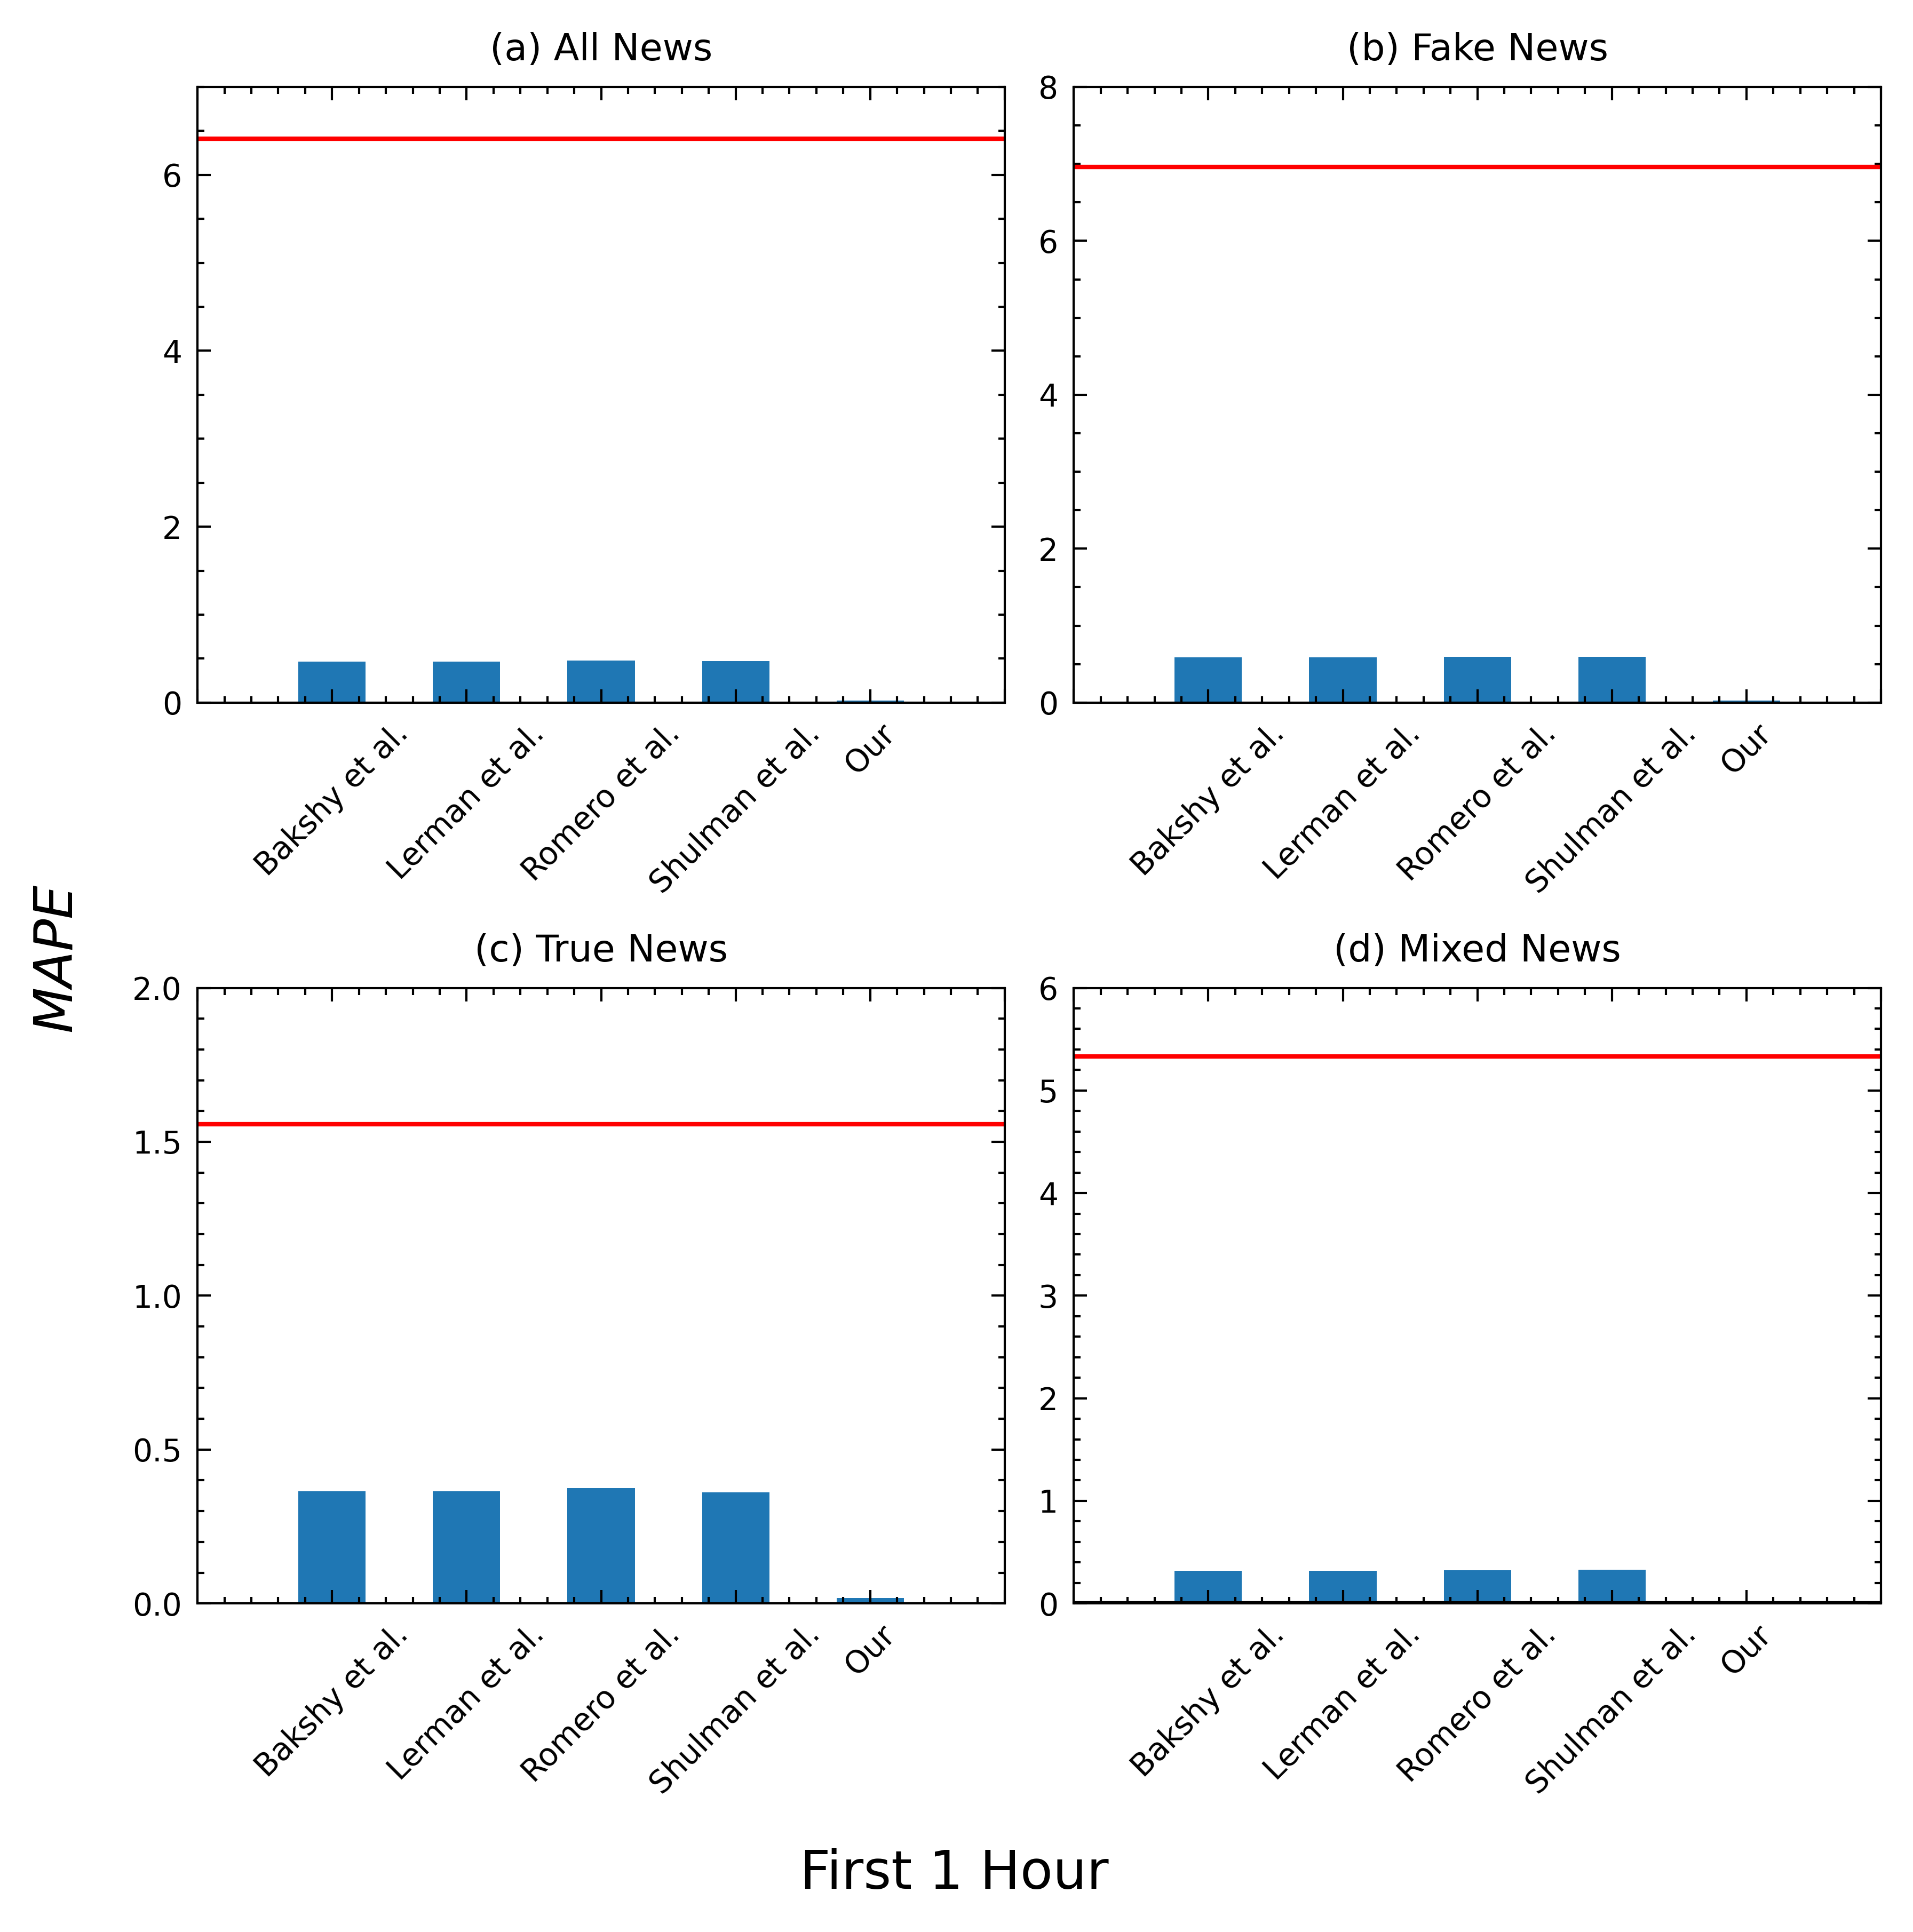

In [131]:
import numpy as np
import matplotlib.pyplot as plt  
with plt.style.context(['science', 'nature', 'no-latex']):
    fig = plt.figure(figsize=(6,6), dpi=600)
    c = 'tab:blue'
    rfmodel2_allnews = 6.410139399480783
    rfmodel2_falsenews = 6.958432661610942
    rfmodel2_truenews = 1.5563254470329588
    rfmodel2_mixednews = 5.329460449930295
    x = [1,2,3,4,5]
    
    ax = fig.add_subplot(221)   
    plt.axhline(y = rfmodel2_allnews, color='r', linestyle='-')    
    plt.bar(x,Compare_T_MAPE['allnews'],width = 0.5,color = c)
    xticks = ['','Bakshy et al.','Lerman et al.',
              'Romero et al.','Shulman et al.',
              'Our','']
    xlabels = [i for i in xticks]
    ax.set_xticks(range(len(xticks)))
    ax.set_xticklabels(xlabels,rotation=45)
    plt.title('(a) All News')
    plt.ylim(0,7)
    
    ax = fig.add_subplot(222)   
    
    plt.axhline(y = rfmodel2_falsenews, color='r', linestyle='-')    
    plt.bar(x,Compare_T_MAPE['falsenews'],width = 0.5,color = c)
    xticks = ['','Bakshy et al.','Lerman et al.',
              'Romero et al.','Shulman et al.',
              'Our','']
    xlabels = [i for i in xticks]
    ax.set_xticks(range(len(xticks)))
    ax.set_xticklabels(xlabels,rotation=45)
    plt.title('(b) Fake News')
    plt.ylim(0,8)

    ax = fig.add_subplot(223)   
    plt.axhline(y = rfmodel2_truenews, color='r', linestyle='-')    
    plt.bar(x,Compare_T_MAPE['truenews'],width = 0.5,color = c)
    xticks = ['','Bakshy et al.','Lerman et al.',
              'Romero et al.','Shulman et al.',
              'Our','']
    xlabels = [i for i in xticks]
    ax.set_xticks(range(len(xticks)))
    ax.set_xticklabels(xlabels,rotation=45)
    plt.title('(c) True News')
    plt.ylim(0,2)
    
    ax = fig.add_subplot(224)   
    plt.axhline(y = rfmodel2_mixednews, color='r', linestyle='-')  
    plt.axhline(y = 0, color='black', linestyle='-')        
    plt.bar(x,Compare_T_MAPE['mixednews'],width = 0.5,color = c)
    xticks = ['','Bakshy et al.','Lerman et al.',
              'Romero et al.','Shulman et al.',
              'Our','']
    xlabels = [i for i in xticks]
    ax.set_xticks(range(len(xticks)))
    ax.set_xticklabels(xlabels,rotation=45)
    plt.title('(d) Mixed News')
    plt.ylim(0,6)
    fig.supylabel('$MAPE$',fontsize = 12)

    fig.supxlabel('First 1 Hour', fontsize = 12)
    plt.tight_layout()
    plt.savefig('Figure 9.pdf',bbox_inches="tight")    

# Figure 10

In [100]:
# binary k=5
X = binary_k[['Spread Time','Breadth','Depth','Size','Virality',
              'Degree','Reach','Density','Edge','K5 Degree',
              'Followees','Followers','Engagement','Verified','Account Age',
              'Business','Politics','Entertainment','NaturalDisasters',
              'Science/Nature/Tech/Food/Health','ViralPhotos/Stories/UrbanLegends','War/Terrorism/Shootings',
              'Dawn','Morning','Noon','Afternoon','Evening','Midnight', 
              'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]
y = binary_k['veracity (0=0, 1=1, 2=2)']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=0,
                              train_size=0.7, test_size = 0.3)
model1 = RandomForestClassifier(n_estimators=35,random_state=0)
model1.fit(X_train,Y_train)
feature_names = [i for i in X]
importances1 = model1.feature_importances_
std = np.std([tree.feature_importances_ for tree in model1.estimators_], axis=0)

forest_importances1 = pd.Series(importances1, index=feature_names)

# binary t=1
X = binary_t[['Unique User','Breadth','Depth','Size','Virality',
              'Degree','Reach','Density','Edge','T1 Degree',
              'Followees','Followers','Engagement','Verified','Account Age',
              'Business','Politics','Entertainment','NaturalDisasters',
              'Science/Nature/Tech/Food/Health','ViralPhotos/Stories/UrbanLegends','War/Terrorism/Shootings',
              'Dawn','Morning','Noon','Afternoon','Evening','Midnight', 
              'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]
y = binary_t['veracity (0=0, 1=1, 2=2)']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=0,
                              train_size=0.7, test_size = 0.3)
model2 = RandomForestClassifier(n_estimators=35,random_state=0)
model2.fit(X_train,Y_train)
feature_names = [i for i in X]
importances2 = model2.feature_importances_
std = np.std([tree.feature_importances_ for tree in model2.estimators_], axis=0)

forest_importances2 = pd.Series(importances2, index=feature_names)

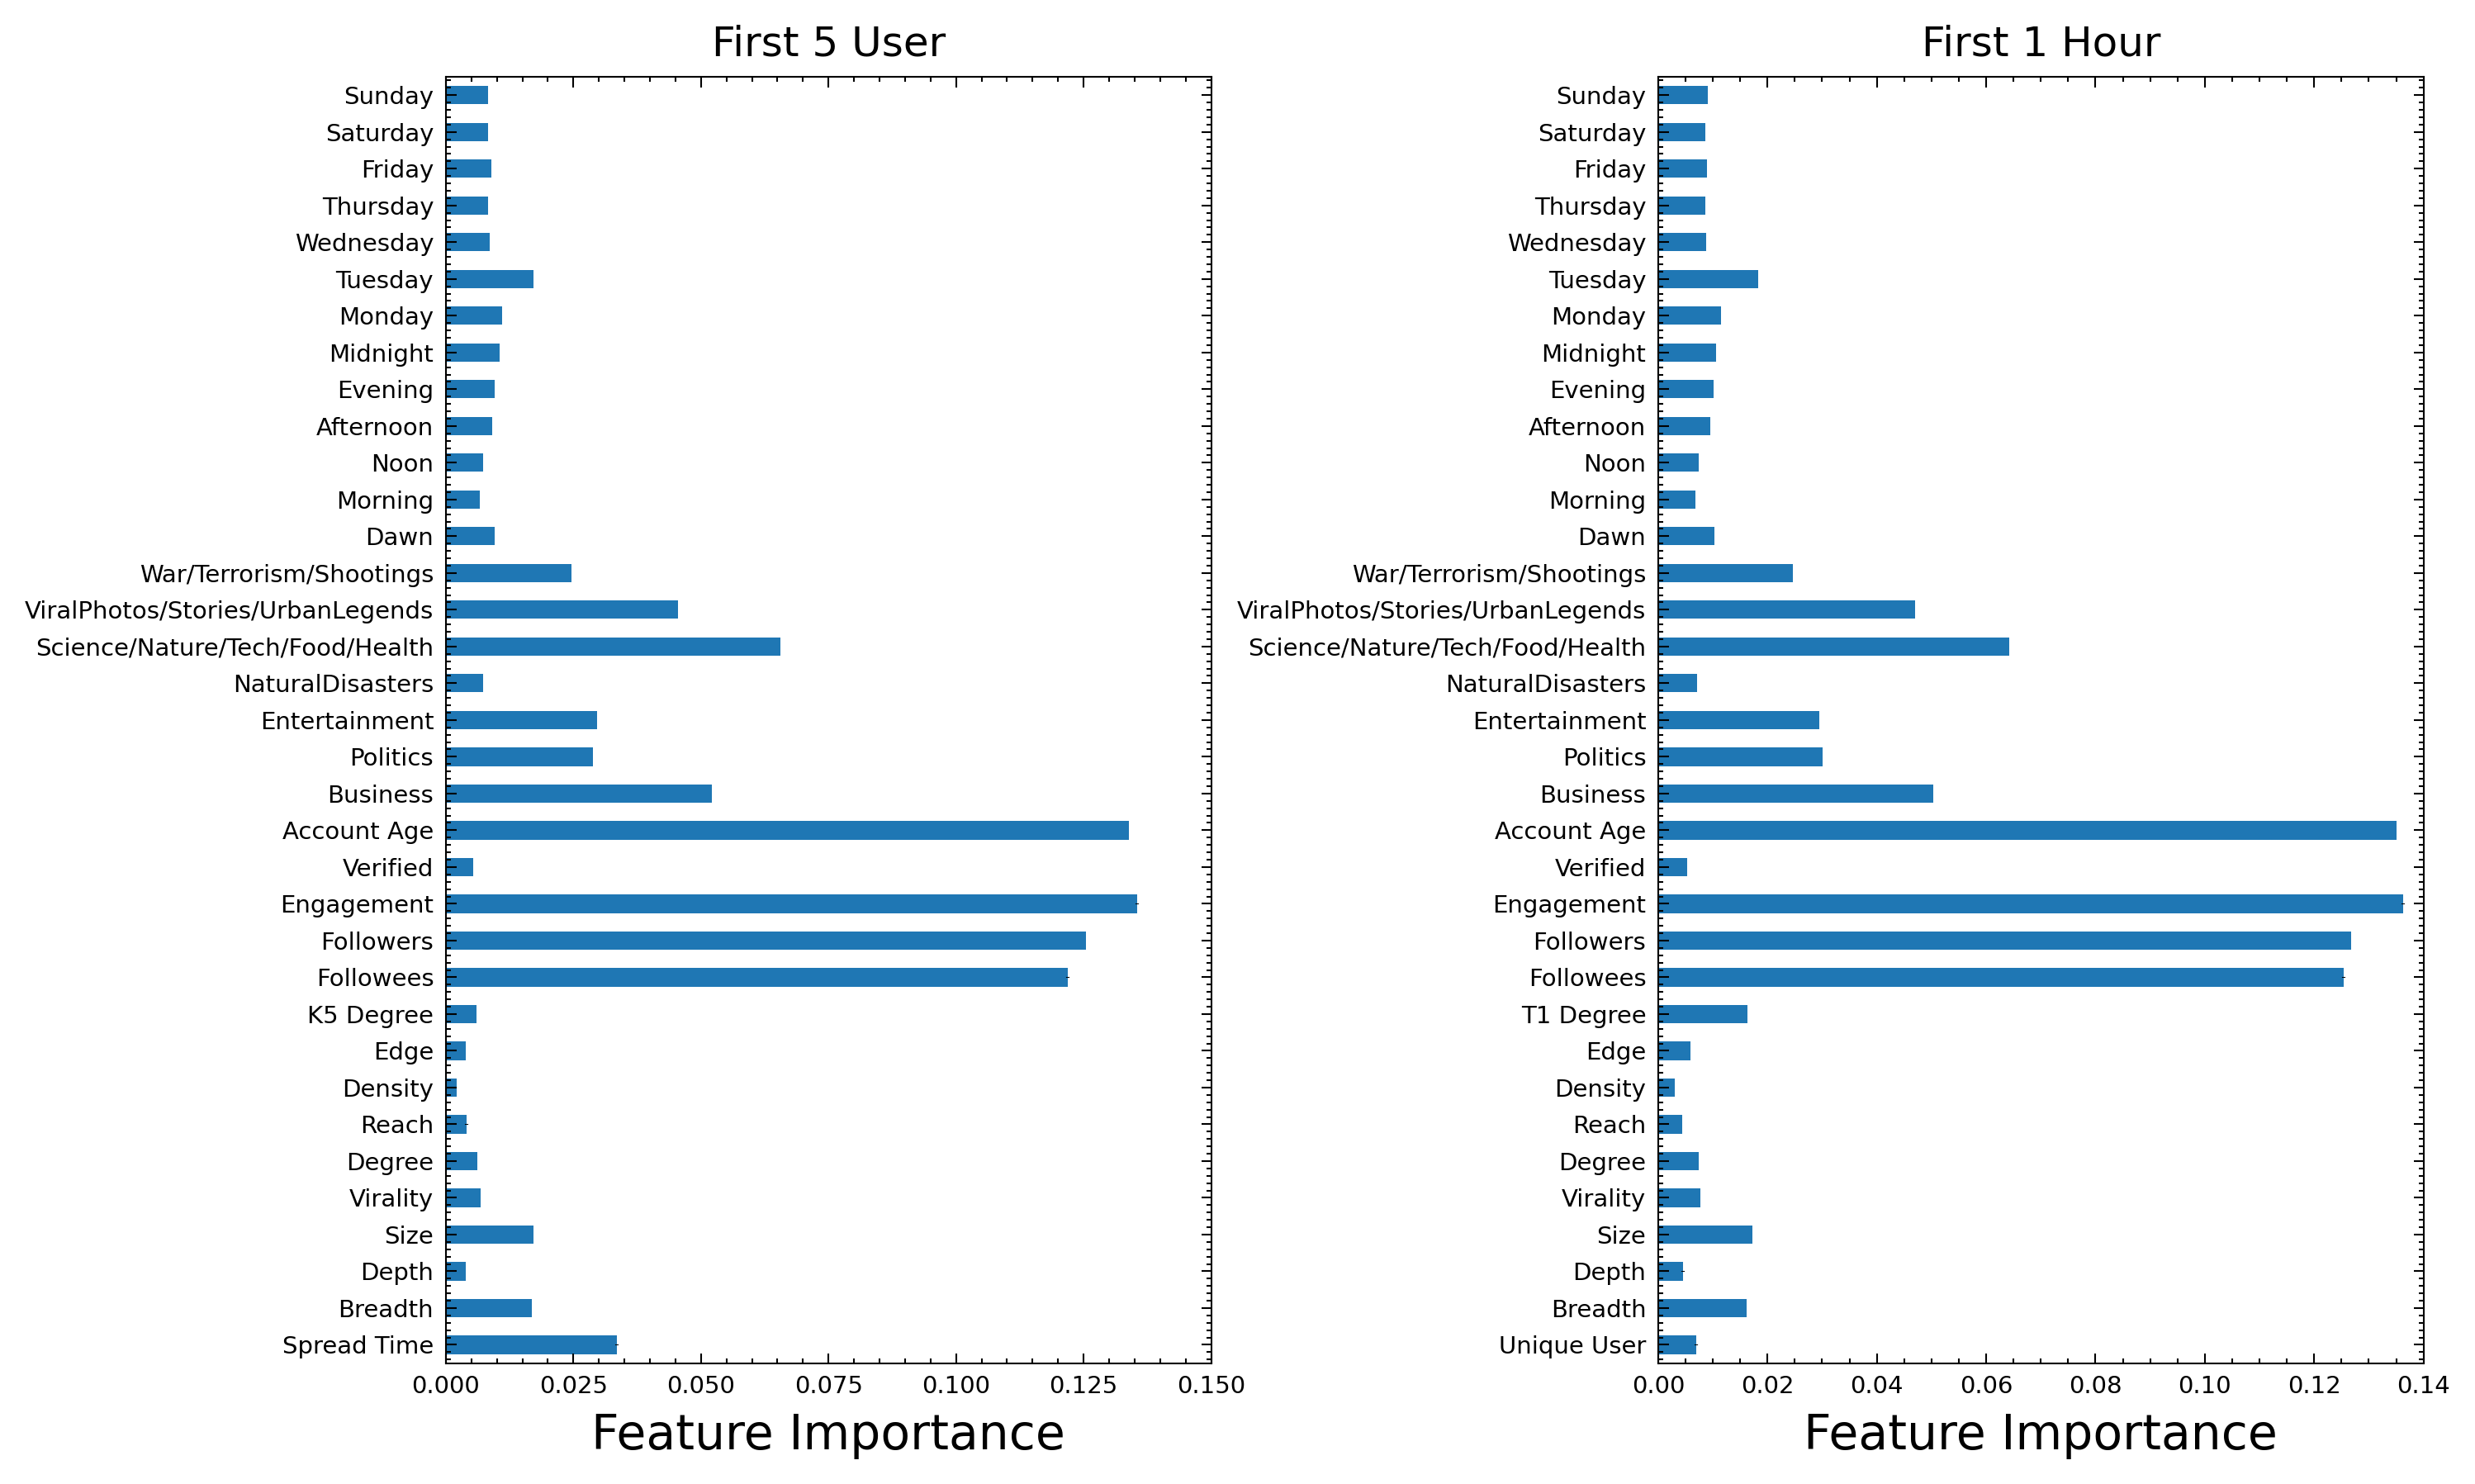

In [101]:
with plt.style.context(['science','nature', 'no-latex']):
    fig = plt.figure(figsize=(10,6), dpi=300)
    plt.subplot(121)
    forest_importances1.plot.barh(yerr=result1.importances_std,color = 'tab:blue')
    plt.title("First 5 User",fontsize = 12)
    xlim(0,0.15)
    plt.xlabel('Feature Importance',fontsize = 14)
    
    plt.subplot(122)
    forest_importances2.plot.barh(yerr=result2.importances_std,color = 'tab:blue')
    plt.title("First 1 Hour",fontsize = 12)
    xlim(0,0.14)
    plt.xlabel('Feature Importance',fontsize = 14)

    plt.tight_layout()
    #plt.savefig('Figure 10.pdf')